#Introduction
In the realm of analog integrated circuit (IC) design, the operational amplifier (op-amp) circuit, whose purpose is to amplify any differential signals, is a fundamental component of almost every circuit. Therefore, mastering op-amp design is essential for any analog circuit engineering. However, the complex, nonlinear relationship between the geometrical parameters (e.g., width and length) and the electrical characteristics of each Metal-Oxide-Semiconductor Field-Effect Transistor (MOSFET) within the op-amp makes it challenging to model a direct mathematical relationship between individual transistor attributes and circuit performance. Consequently, analog circuit design, including op-amp design, heavily relies on expert intuition to identify optimal transistor dimensions within an expansive design space. Further complicating this process, the electrical characteristics of transistors vary across technology nodes, requiring designers to adapt to new node-specific characteristics when transitioning designs to different technologies.  

Addressing these challenges, in this project, we propose a black-box machine learning (ML) model called Extreme Gradient Boosting (XGBoost) to capture the relationship between component parameters and performance metrics in op-amp circuits. After training the black-box model, we employ an explainable artificial intelligence (XAI) technique called Shapley Additive Explanations (SHAP) to analyze how each component parameter impacts specific performance metrics, thereby providing actionable design insights. Additionally, this study incorporates transfer learning to bridge knowledge from TSMC N65 to the SKY130 technology node, facilitating efficient design adaptation to a new technology node.

#1. Import necessary library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install xgboost
!pip install shap

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import xgboost as xgb  # XGBoost
import shap  # For explainable AI
import matplotlib.pyplot as plt



#2. Data loading and preprocessing
The first dataset is collected from simulation results for an op-amp circuit designed in TSMC N65 technology. It consists of 11 CSV files, with each file containing 800 rows representing 800 independent simulations. In each file, the columns are values of VIN, VB1, C0, R0, L1, W1, L2, W2, L3, W3, L4, W4, L5, W5, Power, Gain, BW_3dB, UGB, PM, and GM respectively. The first 14 columns represent input features, and the remaining columns represent output performance metrics. The unit of L1, …, L5 are nanometer (nm); W1, …, W5 are micrometer (μm); C0 is picofarad (pF), R0 is kiloohm (kΩ), other features are in their SI units. The dataset was preprocessed to handle missing values and normalize features.

In [ ]:
# Load CSV files into a single DataFrame

file_dir = '/content/drive/MyDrive/DataSet/OPAMP/'
files = os.listdir(file_dir)
df = pd.read_csv(os.path.join(file_dir, files[0]),header=None)
# Separate input and output features
for e in files[1:]:
    df2 = pd.read_csv(os.path.join(file_dir, e),header=None)
    df = pd.concat((df, df2))


In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
count,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,...,8800.000000,8800.000000,8800.000000,8800.000000,8800.000000,8.800000e+03,8.800000e+03,8800.000000,8800.000000,0.0
mean,563.045114,772.048636,2.142045,2.252386,621.443068,50.959091,671.764318,38.212841,526.872159,47.190455,...,63.632273,639.197386,38.317841,0.000161,46.369998,4.910880e+05,3.961760e+07,70.764682,26.905206,NaN
std,181.476143,153.392422,1.843842,1.670167,252.953202,32.231013,261.243721,24.122072,231.993672,24.213921,...,25.266220,307.373695,26.336152,0.000336,17.027524,1.628325e+06,1.123756e+08,37.511215,44.491676,NaN
min,200.000000,200.000000,1.000000,1.000000,102.000000,1.000000,100.000000,1.000000,101.000000,1.000000,...,1.000000,100.000000,1.000000,0.000002,-34.620110,-1.000000e+01,-1.000000e+01,-893.209000,-680.126000,NaN
25%,436.000000,721.000000,1.000000,1.000000,411.000000,15.000000,509.750000,18.000000,337.000000,28.000000,...,40.000000,329.000000,18.000000,0.000035,32.984075,2.611746e+04,1.047209e+07,61.043025,17.019250,NaN
50%,555.000000,818.000000,1.000000,2.000000,603.000000,63.000000,778.000000,29.000000,576.000000,44.000000,...,69.000000,748.000000,29.000000,0.000062,53.185410,6.324455e+04,1.629576e+07,68.999650,24.243500,NaN
75%,710.000000,870.000000,3.000000,3.000000,885.000000,82.000000,875.000000,62.000000,708.000000,66.000000,...,86.000000,927.000000,54.000000,0.000136,60.283625,3.708460e+05,3.087499e+07,83.071275,33.654975,NaN
max,998.000000,996.000000,9.000000,9.000000,999.000000,99.000000,999.000000,99.000000,998.000000,99.000000,...,99.000000,999.000000,99.000000,0.007195,67.493060,7.476342e+07,2.570507e+09,976.725000,983.732000,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8800 entries, 0 to 799
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       8800 non-null   int64  
 1   1       8800 non-null   int64  
 2   2       8800 non-null   int64  
 3   3       8800 non-null   int64  
 4   4       8800 non-null   int64  
 5   5       8800 non-null   int64  
 6   6       8800 non-null   int64  
 7   7       8800 non-null   int64  
 8   8       8800 non-null   int64  
 9   9       8800 non-null   int64  
 10  10      8800 non-null   int64  
 11  11      8800 non-null   int64  
 12  12      8800 non-null   int64  
 13  13      8800 non-null   int64  
 14  14      8800 non-null   float64
 15  15      8800 non-null   float64
 16  16      8800 non-null   float64
 17  17      8800 non-null   float64
 18  18      8800 non-null   float64
 19  19      8800 non-null   float64
 20  20      0 non-null      float64
dtypes: float64(7), int64(14)
memory usage: 1.5 

In [ ]:
df = df.drop(df.columns[20], axis=1)

column_names = ['VIN', 'VB1', 'C0', 'R0', 'L1', 'W1', 'L2', 'W2', 'L3', 'W3','L4', 'W4', 'L5', 'W5', 'Power', 'Gain', 'BW_3dB', 'UGB', 'PM', 'GM']

df.columns = pd.Index(column_names)

# Separate input and output features
input_columns = ['VIN', 'VB1', 'C0', 'R0', 'L1', 'W1', 'L2', 'W2', 'L3', 'W3', 'L4', 'W4', 'L5', 'W5']
output_columns = ['Power', 'Gain', 'BW_3dB', 'UGB', 'PM', 'GM']

X = df[input_columns]
y = df[output_columns]



**Normalization**: The StandardScaler was used to normalize the data by standardizing features to a mean of zero and a standard deviation of one, ensuring all features contributed equally to the learning process, improving model convergence and stability.


In [ ]:
# Normalize input features for better performance
scaler = StandardScaler()
X = scaler.fit_transform(X)

#3. Training and evaluating black-box models

##3.1. Model Defining

In [ ]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators= 100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='reg:squarederror'
)

# Define the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    random_state=42
)


##3.3. XGBoost's Model Training and Evaluation
The trained model is evaluated by using **mean squared error** (MSE) and **R²**. These metrics are chosen to quantify both the accuracy of the predictions and the proportion of variance explained by the model. Additionally, to prevent the overfitting to a specific set of data and provide a reliable estimate of its generalization capability, five-fold **cross-validation** approach is employed to validate model performance across different dataset's subsets.

In [ ]:
def evaluate_model(model, X, y):


  # Train an XGBoost model for each output feature using cross-validation
  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  results = {}

  test_mse_list = []
  test_r2_list = []

  for output in output_columns:
      y_single = y[output]

      # Cross-validation for the current output feature
      cv_mse_scores = -cross_val_score(model, X, y_single, cv=kf, scoring='neg_mean_squared_error')
      cv_r2_scores = cross_val_score(model, X, y_single, cv=kf, scoring='r2')
      mean_cv_mse = np.mean(cv_mse_scores)
      std_cv_mse = np.std(cv_mse_scores)
      mean_cv_r2 = np.mean(cv_r2_scores)

      # Save the evaluation metrics
      results[output] = {
          "Cross-Validation MSE (± Standard deviation)": f"{mean_cv_mse:.2f} ± {std_cv_mse:.2f}",
          "Cross-Validation R2": mean_cv_r2,
      }

      # Collect test MSE and R^2 scores for plotting
      test_mse_list.append(mean_cv_mse)
      test_r2_list.append(mean_cv_r2)

      # Plot MSE and R^2 scores for each fold
      plt.figure(figsize=(12, 5))
      plt.subplot(1, 2, 1)
      plt.plot(range(1, kf.n_splits + 1), cv_mse_scores, marker='o', linestyle='-', color='b')
      plt.xlabel('Fold')
      plt.ylabel('MSE')
      plt.title(f'{output} - Cross-Validation MSE Scores')

      plt.subplot(1, 2, 2)
      plt.plot(range(1, kf.n_splits + 1), cv_r2_scores, marker='o', linestyle='-', color='g')
      plt.xlabel('Fold')
      plt.ylabel('R^2')
      plt.title(f'{output} - Cross-Validation R^2 Scores')

      plt.tight_layout()
      plt.show()
  # Display the results as a DataFrame
  results_df = pd.DataFrame(results).T

  return results_df, test_mse_list, test_r2_list

In [ ]:

def plot_mean_results(results_df, test_mse_list, test_r2_list,name = " "):
  # Plot Test MSE and R^2 for each output feature
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.bar(output_columns, rf_test_mse_list, color='b')
  plt.xlabel('Output Feature')
  plt.ylabel('Test MSE')
  plt.title(name + '- mean MSE for Each Output Feature')
  plt.xticks(rotation=45)

  plt.subplot(1, 2, 2)
  plt.bar(output_columns, test_r2_list, color='g')
  plt.xlabel('Output Feature')
  plt.ylabel('Test R^2')
  plt.title(name + '- mean R^2 for Each Output Feature')
  plt.xticks(rotation=45)

  plt.tight_layout()
  plt.show()

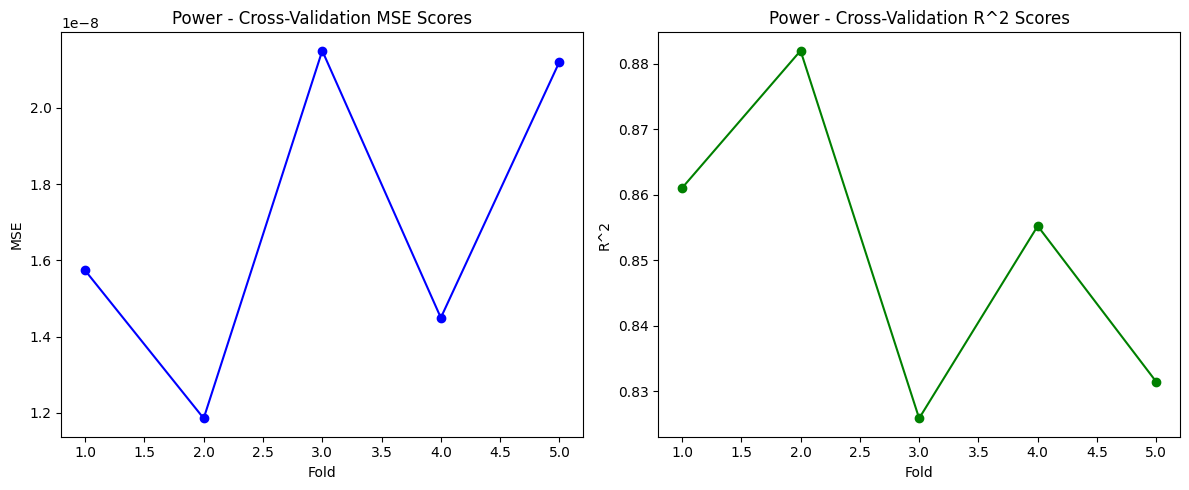

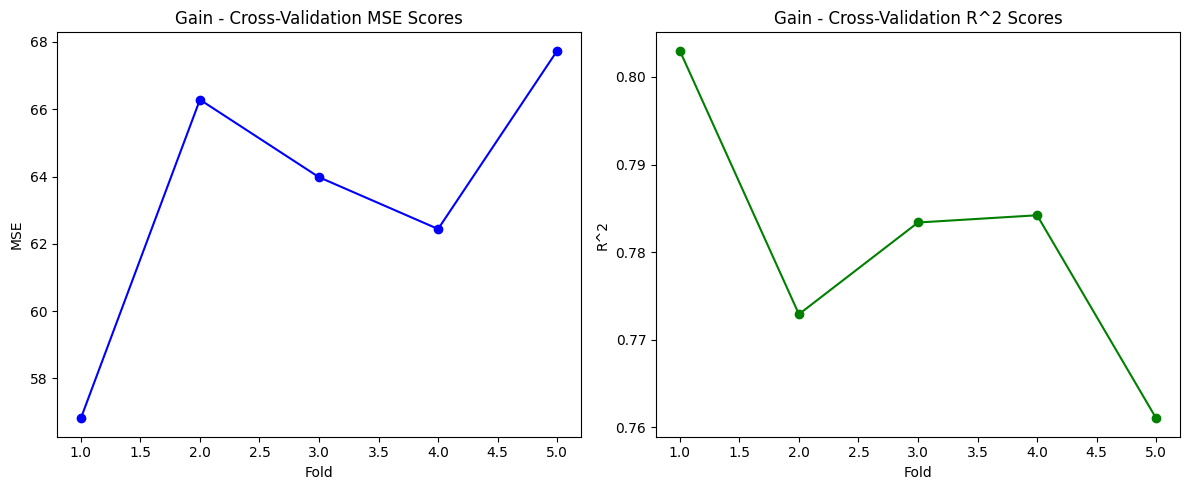

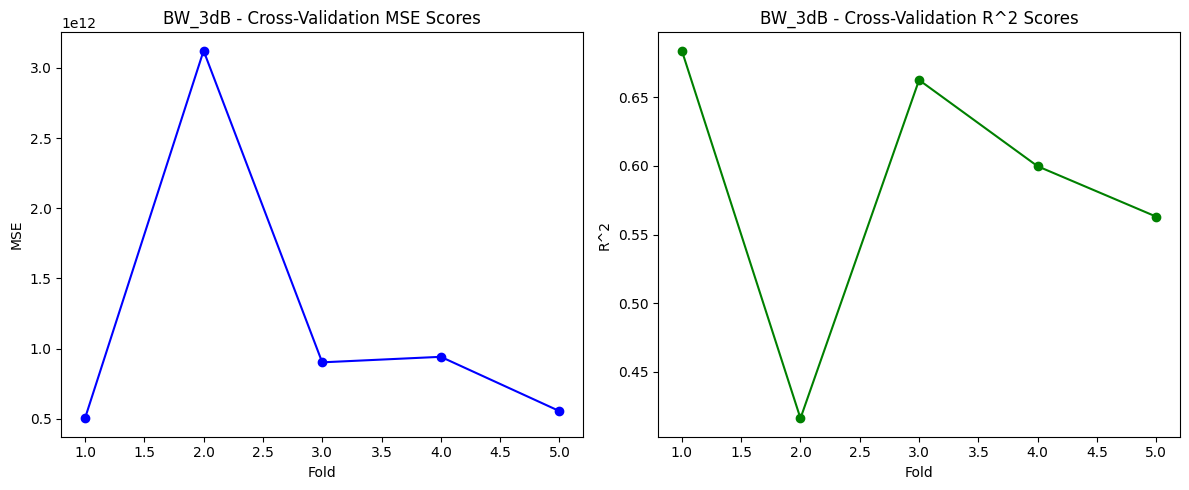

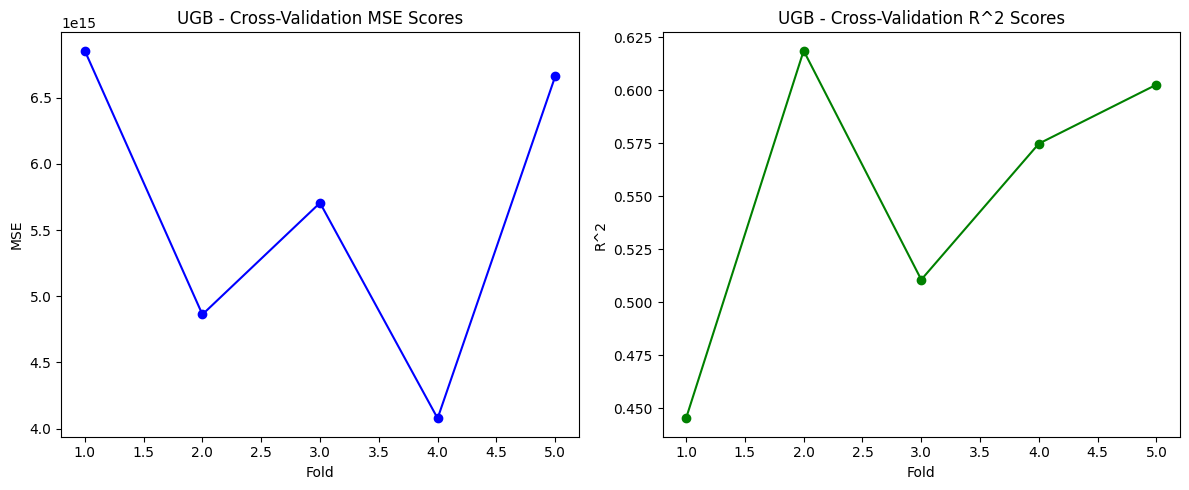

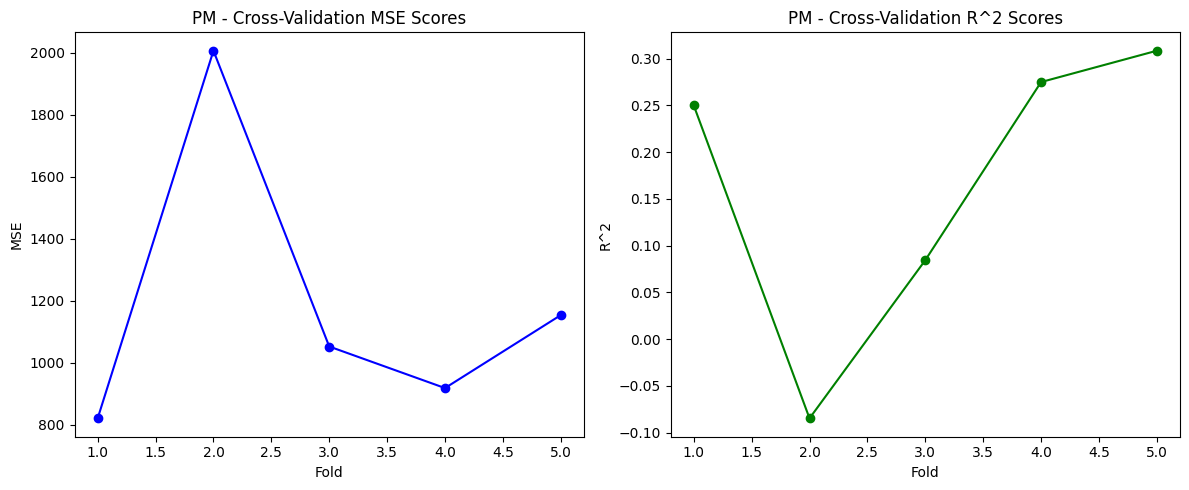

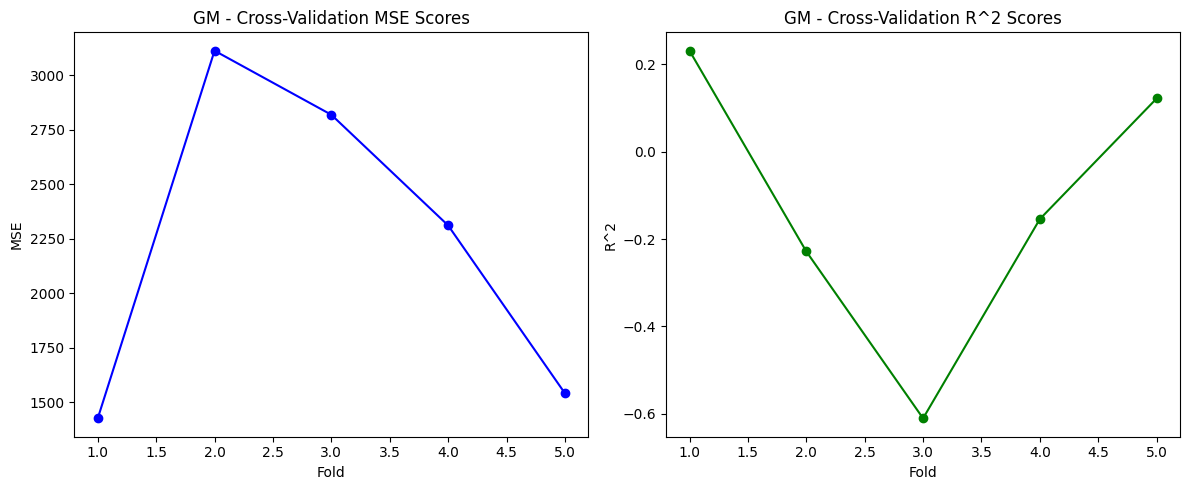

In [ ]:
# evaluate XGBoost model
xgb_results, test_mse_list, test_r2_list = evaluate_model(xgb_model, X, y)

**Key observations from above figures:**
* Inconsistency Across Folds: There is significant variability in model performance across the folds for all metrics, as evidenced by fluctuated MSE and R² scores. Some folds exhibit notably higher errors or lower R² values, indicating instability.
* Negative R² Scores: Metrics like PM and GM show negative R² scores in some folds, suggesting that the model performs worse than simply using the mean value. This highlights overfitting or data quality issues in certain folds.

**Potential Issues:**
* The variability suggests possible data inconsistencies, imbalanced splits, or outliers affecting specific folds.
* The model may need better hyperparameter tuning or more robust feature engineering to achieve consistent results.

**Recommendations:**
* Hyperparameter Tuning and Feature Engineering could help stabilize model performance.
* Data Stratification during cross-validation may improve consistency across folds.

In [ ]:
print("XGboost Evaluate results")
print(xgb_results)

XGboost Evaluate results
       Cross-Validation MSE (± Standard deviation) Cross-Validation R2
Power                                  0.00 ± 0.00            0.851131
Gain                                  63.45 ± 3.79            0.780917
BW_3dB          1205315836330.43 ± 974378692294.83            0.585133
UGB      5632396228993621.00 ± 1055083488804225.88            0.550404
PM                                1190.62 ± 423.65            0.166625
GM                                2241.58 ± 671.23            -0.12799


* MSE of "Power" is 0.00 ± 0.00: great performance but the model may be overfitting

* The model performs well for predicting "Gain," with relatively low MSE and high R² scores, indicating that it captures the relationships effectively for these metrics.

* The metrics "BW_3dB" and "UGB" show moderate R² values and very high MSE, with large variability across folds. This suggests the model is struggling to generalize well and may require more data or feature engineering.

* The metrics "PM" and "GM" have high MSE and low or negative R² values, indicating poor predictive power. The model is unable to accurately capture the relationships for these metrics, possibly due to complexity or insufficient relevant features.

##3.4. Random Forest's Model Training and Evaluation

Similar to the previous part, in this section, the trained model was evaluated by using **mean squared error** (MSE) and **R²**. Five-fold **cross-validation** approach is also employed to validate model performance across different dataset's subsets.

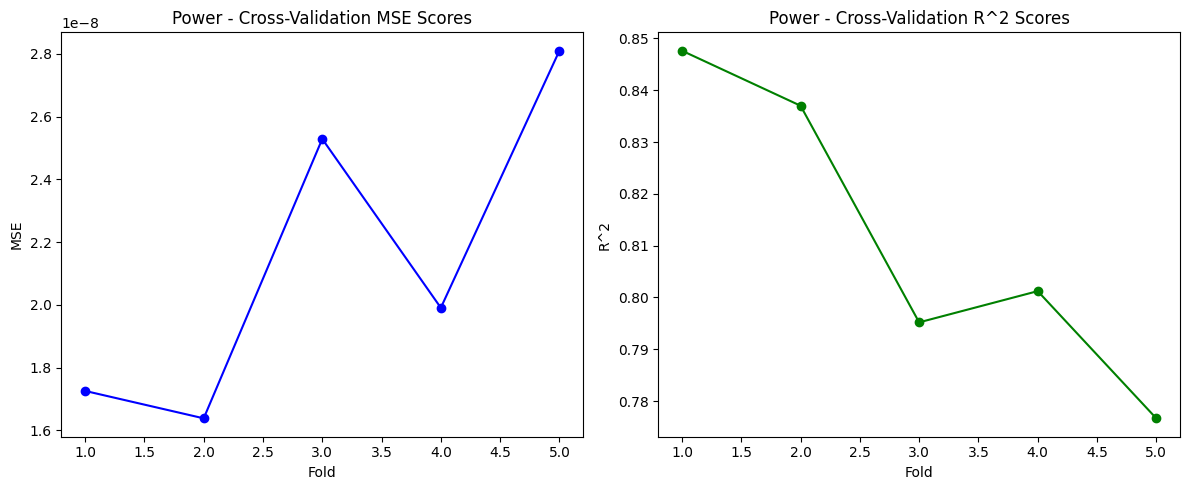

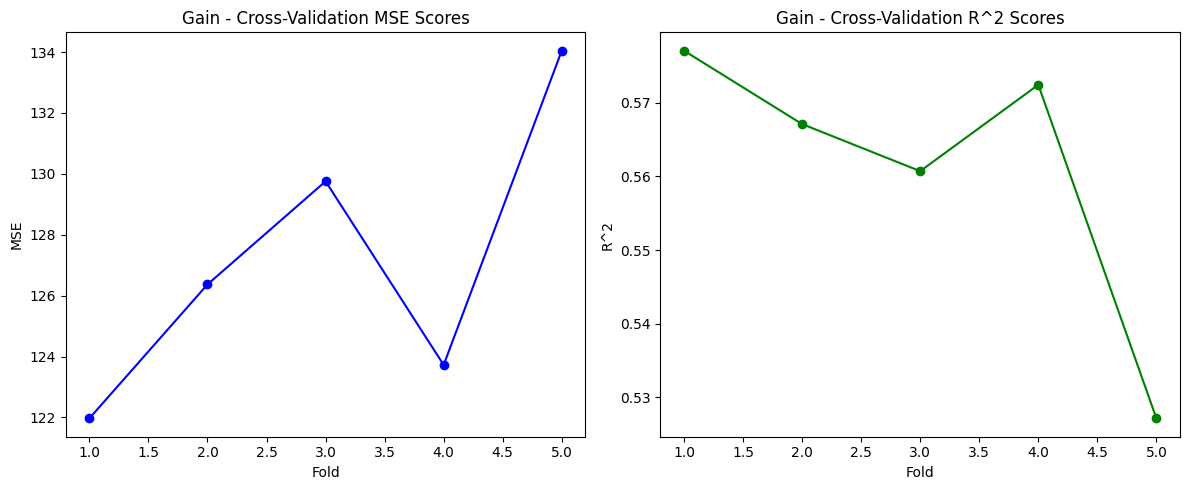

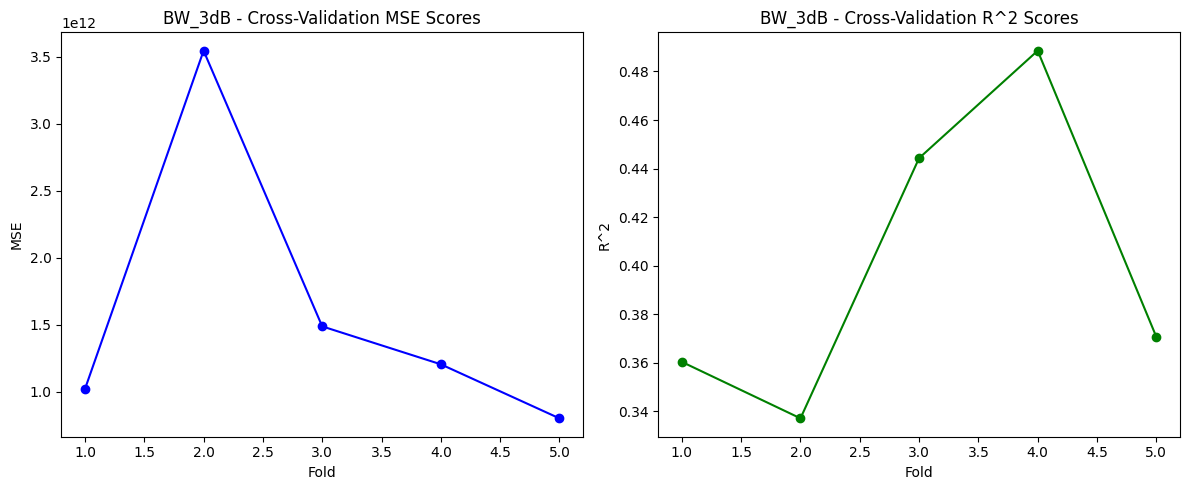

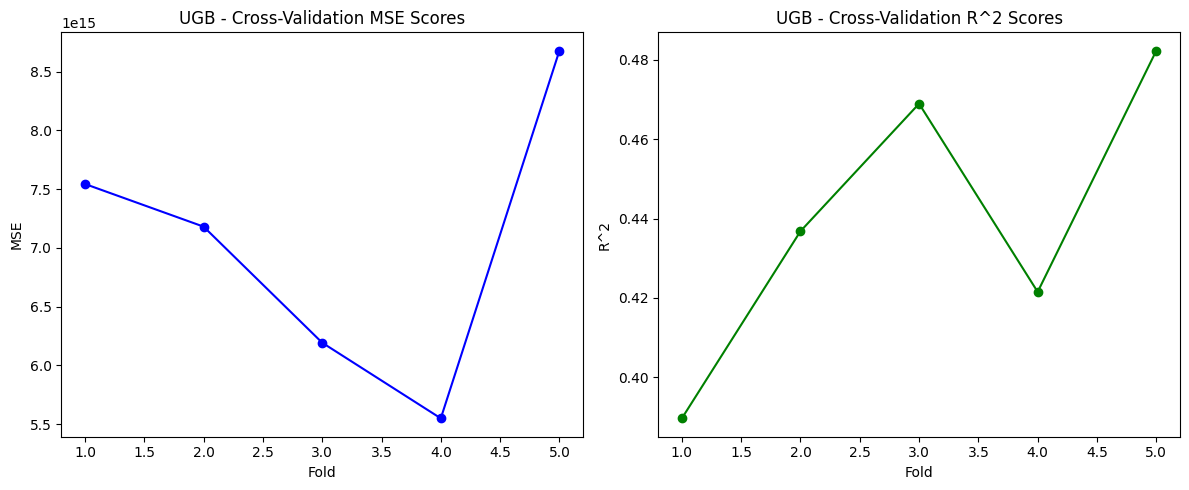

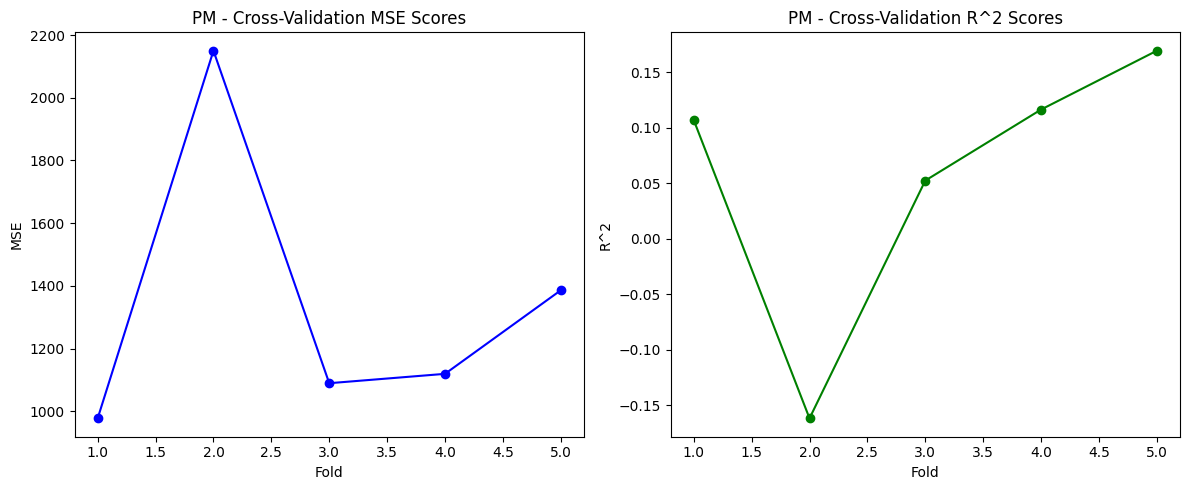

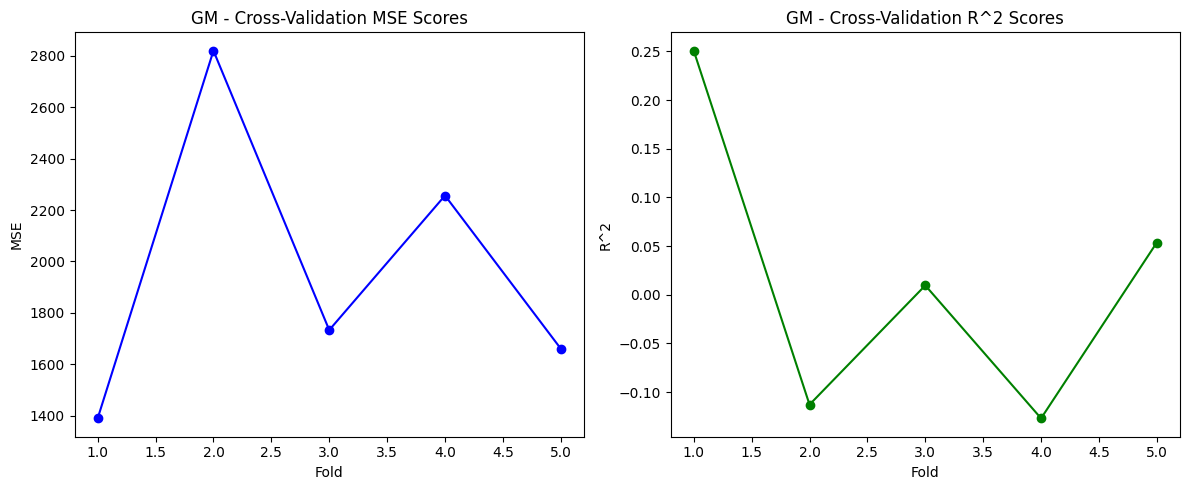

In [ ]:
# evaluate RF model
rf_results, rf_test_mse_list, rf_test_r2_list = evaluate_model(rf_model, X,y)

**Training performance**: Both MSE and R² scores vary widely across the five folds for each metric, indicating that the model struggles with consistent generalization. Metrics like "BW_3dB," "PM," and "GM" show particularly high MSE values and negative R² scores in certain folds, highlighting poor performance in specific data subsets.

**Potential Issues**: could be due to data variability, with certain folds being more challenging for the model to learn from. Morevover, random forest model may also require better tuning to avoid overfitting and handle the complexity of the dataset.

**Recommendations:**

* Hyperparameter Tuning: Improve the model's performance stability by adjusting parameters like n_estimators and max_depth.

* Stratified Cross-Validation: This could help balance data representation across folds, reducing variability.

* Feature Engineering: Evaluate and potentially remove noisy or irrelevant features to enhance generalization.


In [ ]:
print("RF Evaluate results")
print(rf_results)

RF Evaluate results
       Cross-Validation MSE (± Standard deviation) Cross-Validation R2
Power                                  0.00 ± 0.00            0.811549
Gain                                 127.17 ± 4.32            0.560903
BW_3dB          1611246663130.71 ± 992642202673.17            0.400232
UGB      7028309181703604.00 ± 1086091065122252.88            0.439836
PM                                1344.52 ± 424.43            0.056602
GM                                1971.84 ± 508.45            0.014836


* MSE of “Power” is 0.00 ± 0.00: great performance but maybe the model is overfitting.

* The metrics "Gain" and "BW_3dB" have moderate MSE and R² scores, showing some predictive capability, but with notable room for improvement.

* Metrics "UGB", "PM", and "GM" exhibit high MSE, large standard deviations, and low R² scores, indicating poor predictive power and inconsistency across folds.


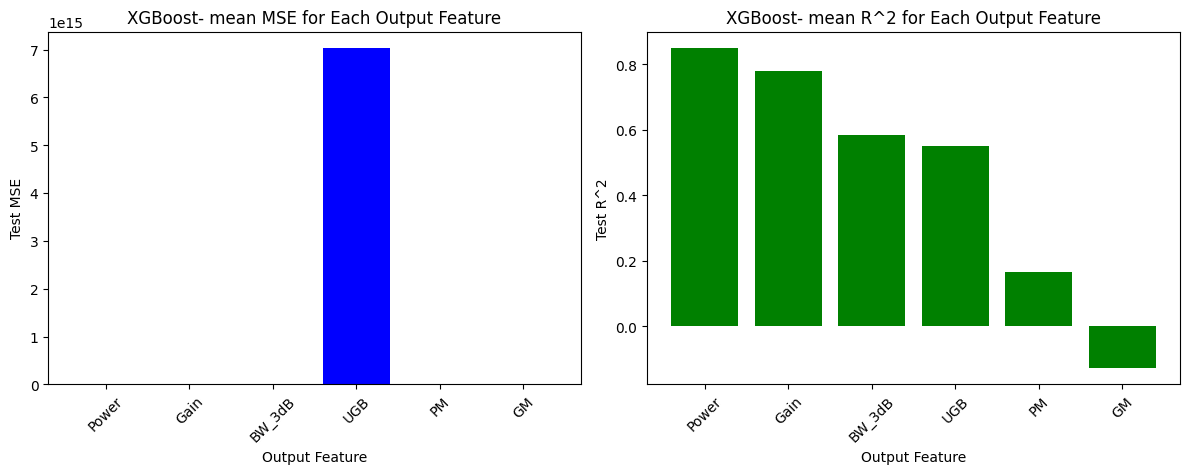

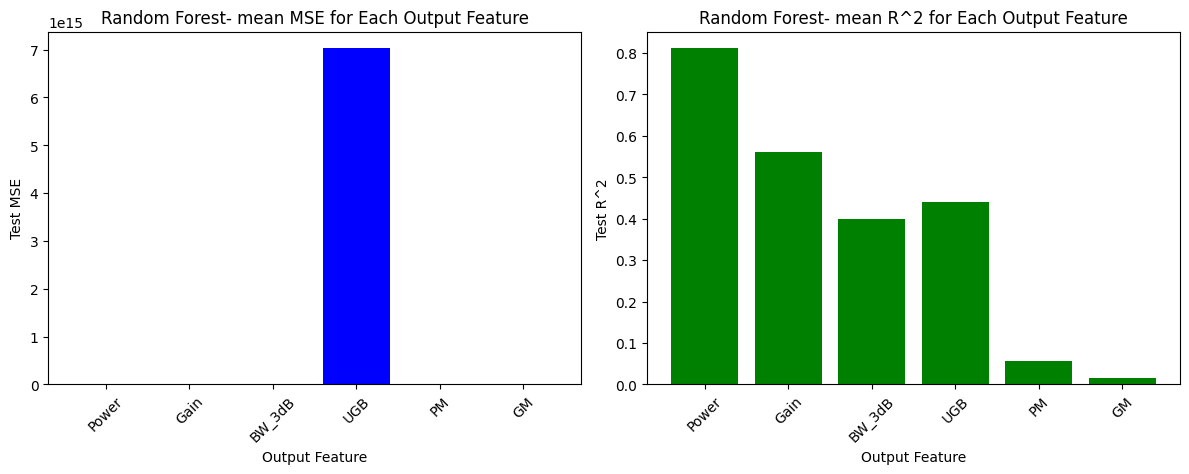

In [ ]:
#plot mean MSE and R^2 Graph
plot_mean_results(xgb_results, test_mse_list, test_r2_list,"XGBoost")
plot_mean_results(rf_results, rf_test_mse_list, rf_test_r2_list, "Random Forest")

Form the mean figures above, we can conclude that XGBoost has better performance compared to random forest in terms of modelling "Power" "Gain", "BW_3dB", "UGB" and "PM". However, the "GM" prediction of XGBoost model is poor. From these results, we believe that **XGBoost is more suitable** that random forest to modle the characristic of the op-amp circuit.


#4. SHAP Explanation

In this part, from the black-box model trained by using XGBoost method, we apply SHAP (SHapley Additive exPlanations) to understand how each component parameter influences specific performance metrics. From the results provided by SHAP, we make some suggestion for circuit designers to notice the key features that may highly affect the op-amp's behavior. For each performance metrics, features that designers should notice are highlighted in **bold**.

**Note**: Sometimes the SHAP values might be very small in magnitude (e.g., 10^-5 or 10^-6). Depending on the precision used in the graphical representation, such small values could be represented as zero.


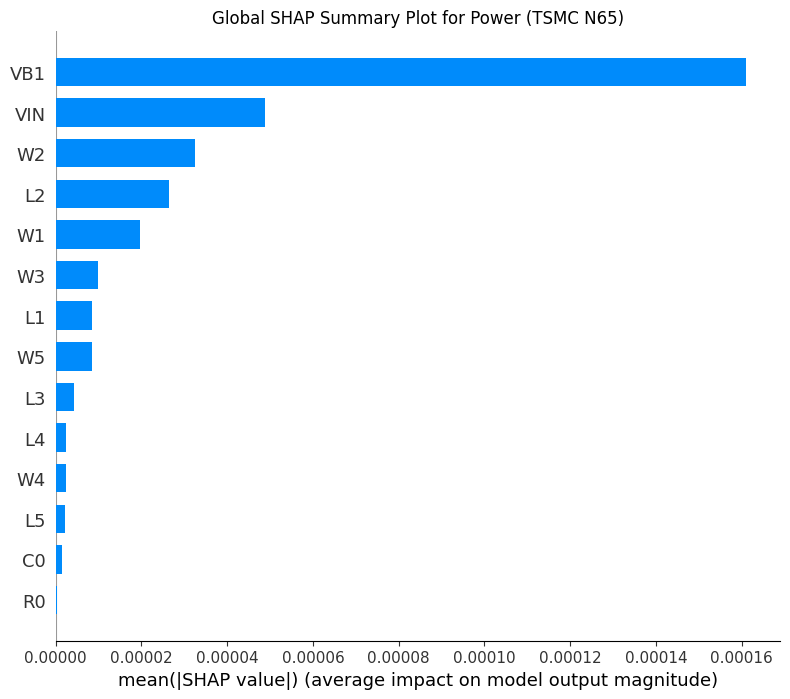

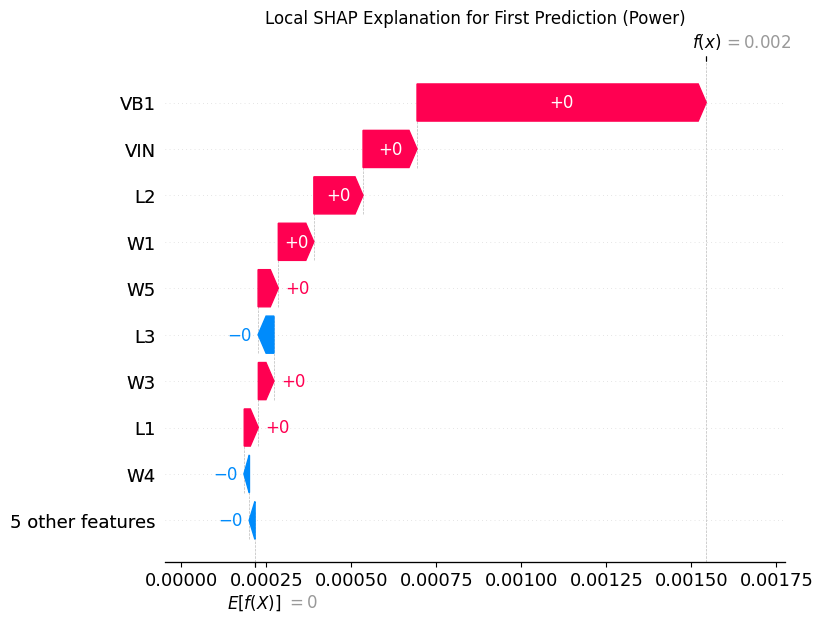

 97%|=================== | 8573/8800 [00:38<00:01]       

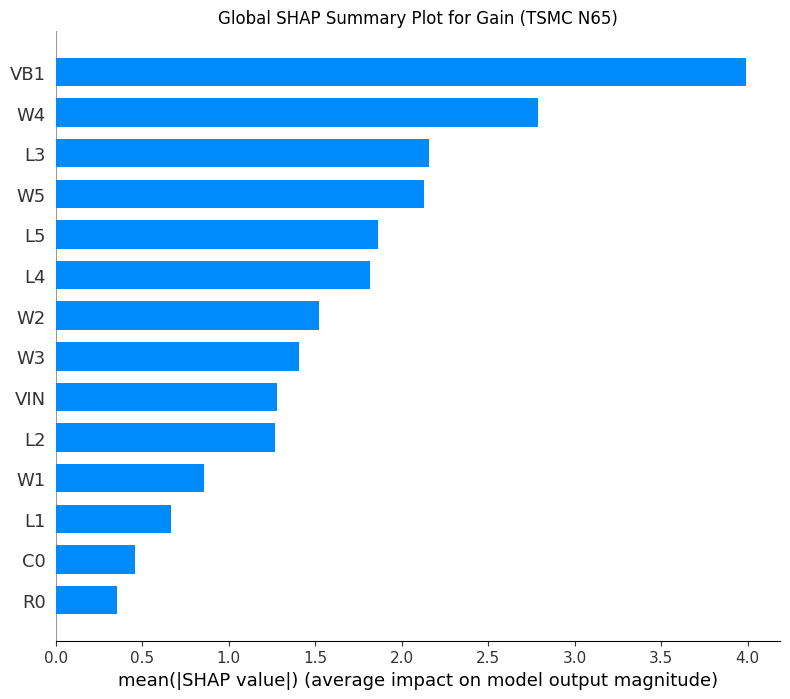

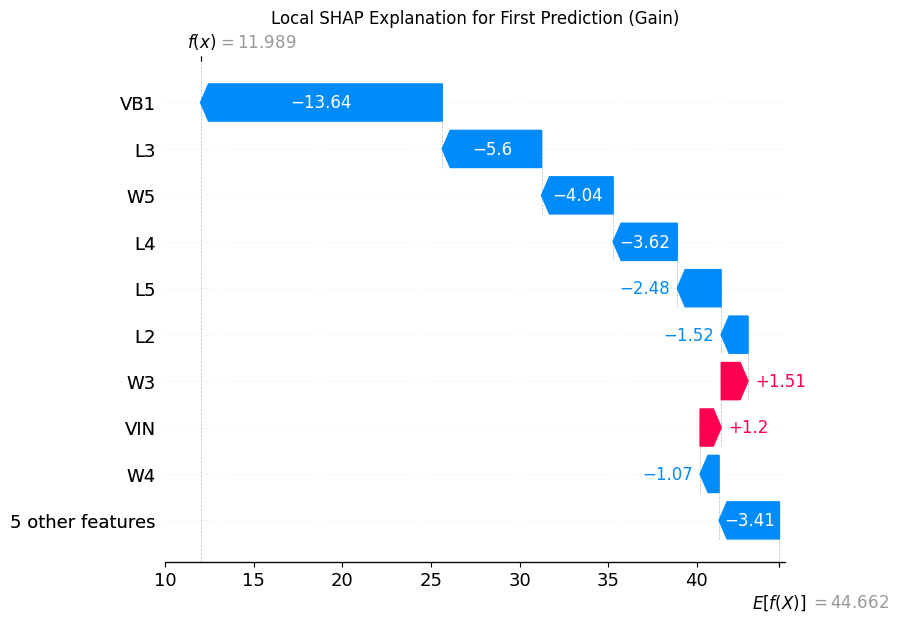

 98%|===================| 8629/8800 [00:31<00:00]       

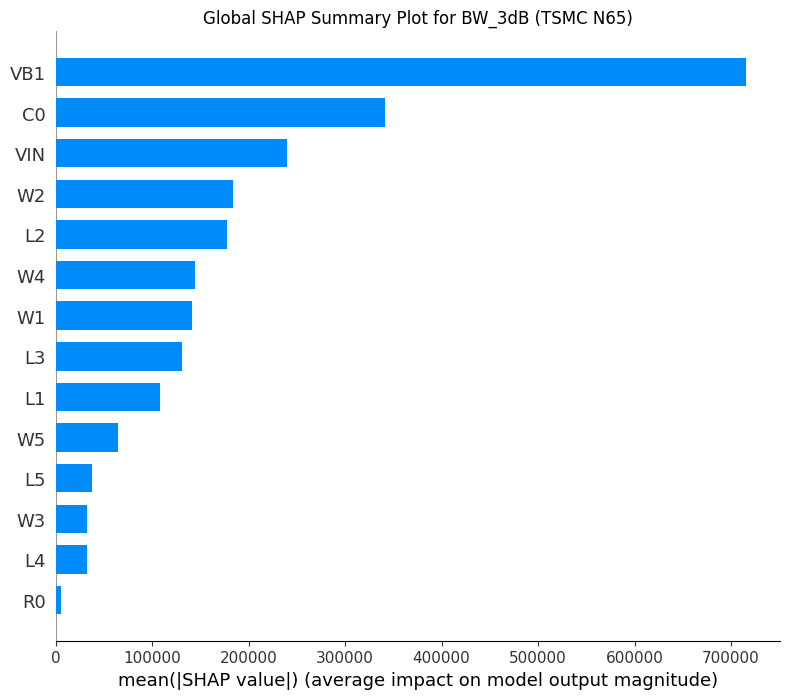

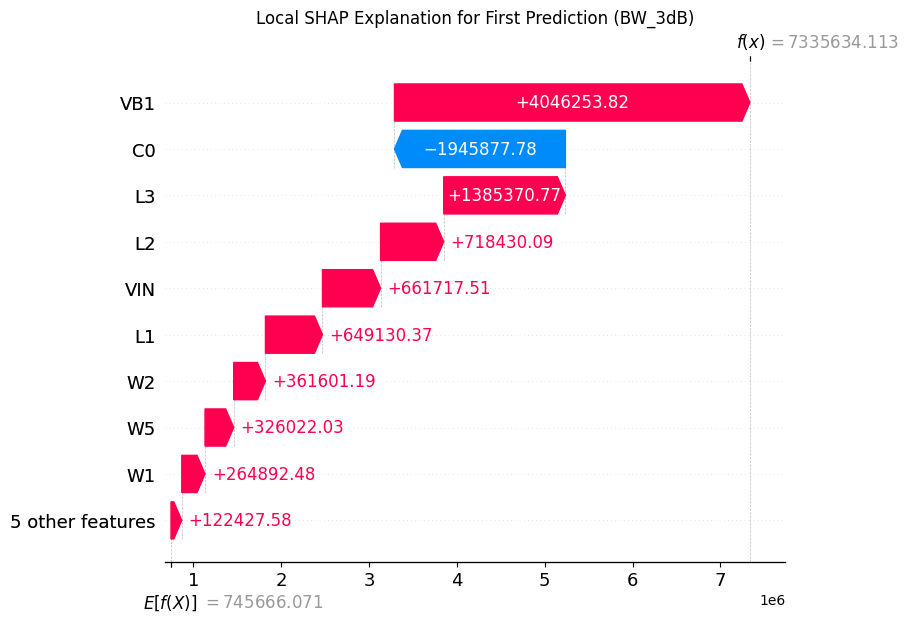

 99%|===================| 8713/8800 [00:38<00:00]       

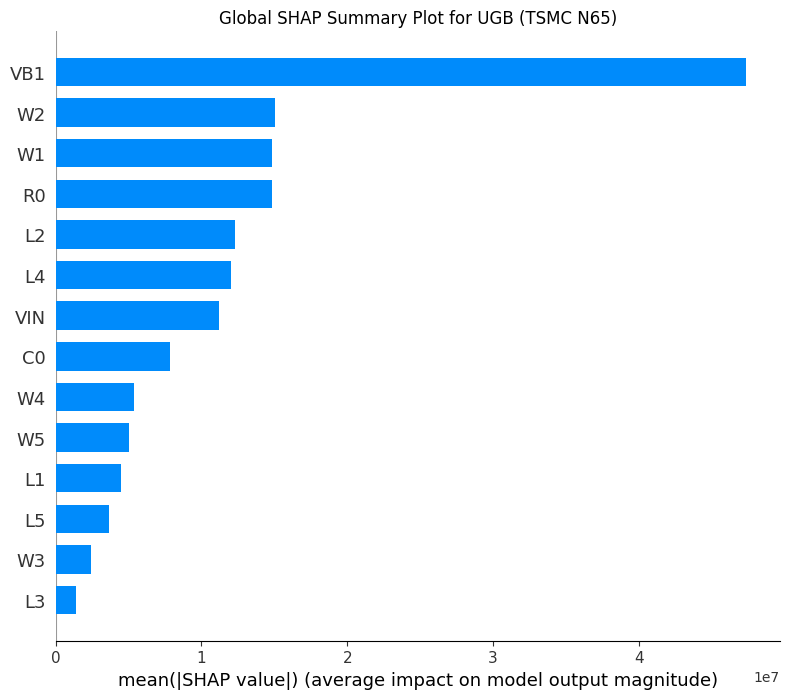

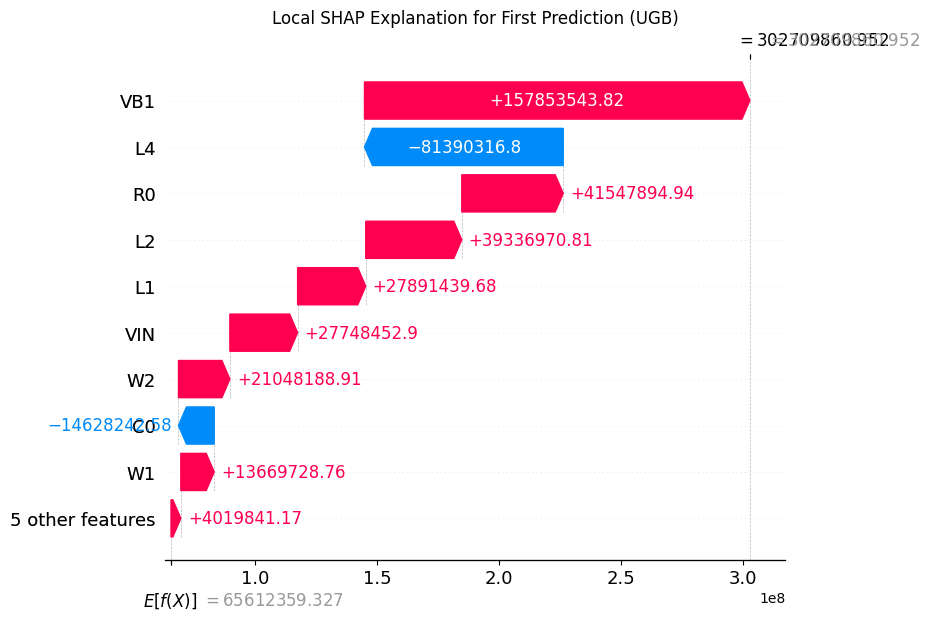

 98%|===================| 8583/8800 [00:40<00:01]       

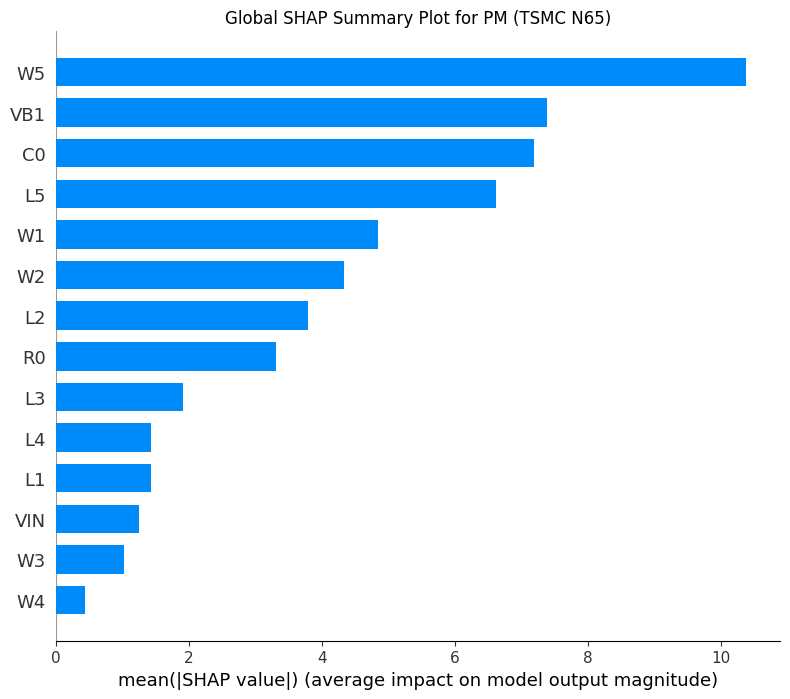

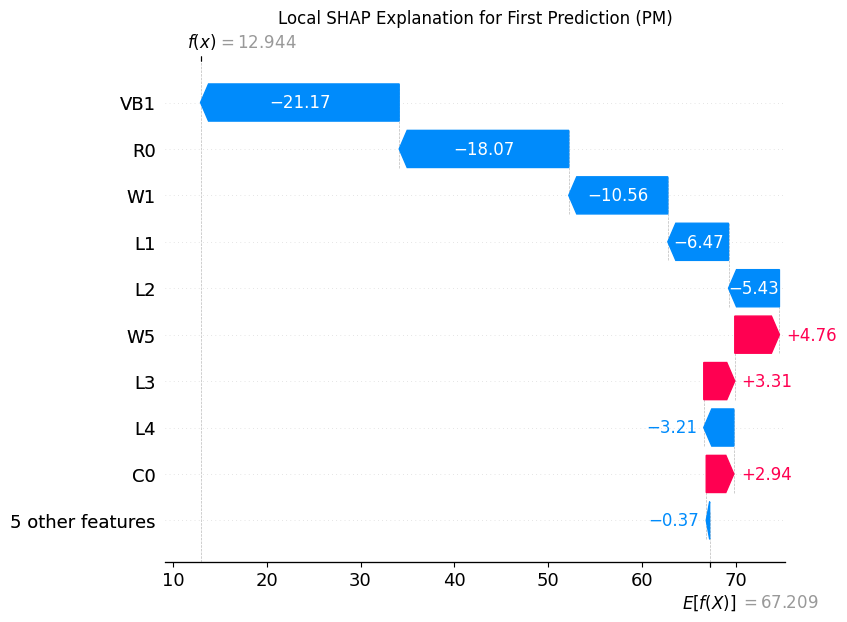

 97%|=================== | 8551/8800 [00:32<00:00]       

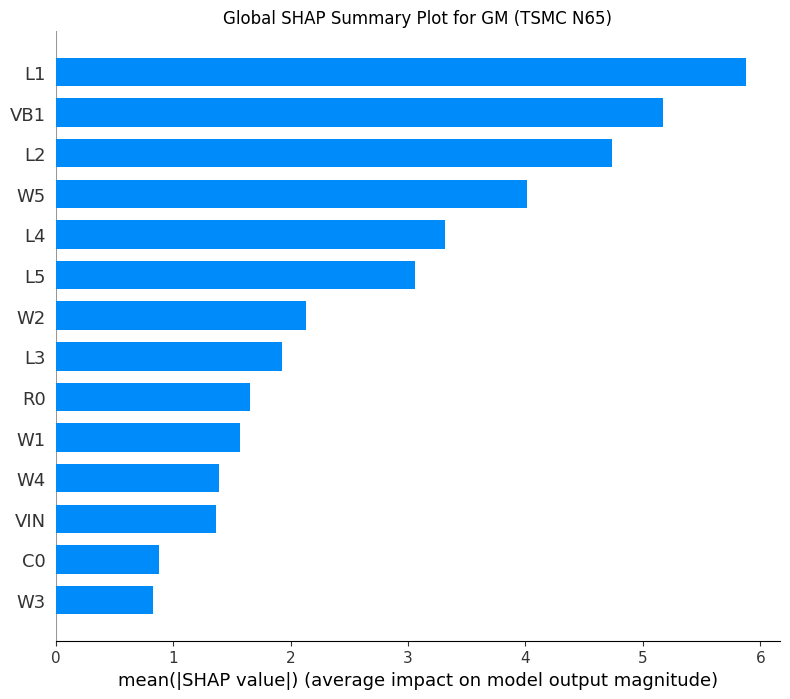

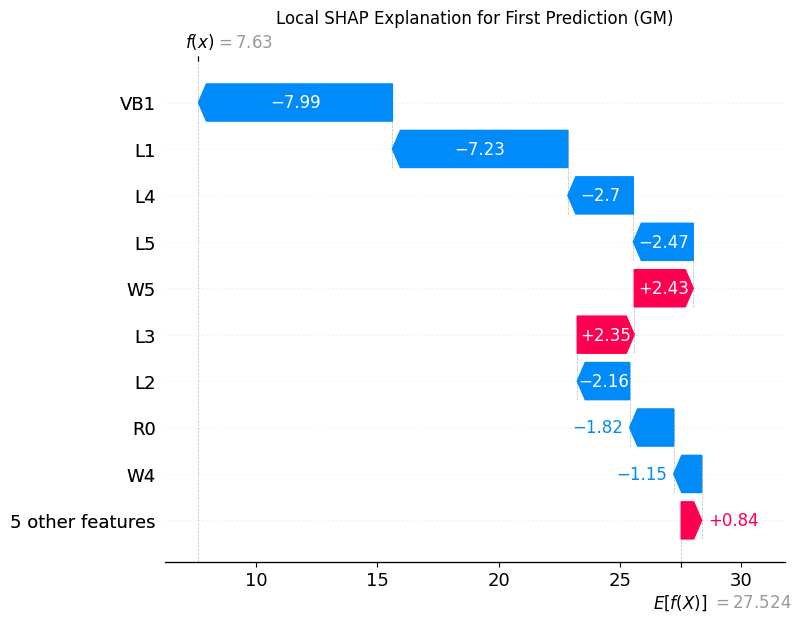

In [ ]:

# Global and Local SHAP Explanations for TSMC N65 models
for output in output_columns:
    xgb_model.fit(X, y[output])
    explainer = shap.Explainer(xgb_model, X)
    shap_values = explainer(X)

    # Global SHAP summary plot
    plt.title(f"Global SHAP Summary Plot for {output} (TSMC N65)")
    shap.summary_plot(shap_values, X, feature_names=input_columns, show=False, plot_type="bar")
    plt.show()

    # Local SHAP explanation for the first instance
    plt.title(f"Local SHAP Explanation for First Prediction ({output})")
    shap.waterfall_plot(
        shap.Explanation(values=shap_values[0].values,
                         base_values=shap_values[0].base_values,
                         feature_names=input_columns)
    )


    plt.show()

##4.1. "Power" explanation result
* Global Importance: The global SHAP summary plot indicates that VB1 and VIN are consistently the most important features influencing the prediction of Power. This suggests that these parameters have a significant effect on power consumption in the op-amp circuit, making them key targets for optimization.

* Local Impact: The local SHAP explanation highlights how specific features affect individual predictions. For the given instance, VB1 played the largest role in determining the predicted Power, indicating that changes in this parameter could have a significant impact on power performance for this specific scenario.

* Design Implications: Designers should focus on optimizing **VB1** and **VIN** to effectively manage and improve power consumption. Understanding how other features, such as **L2, W1, and W5**, influence power can further refine the design process.


##4.2. "Gain" explanation result
* Global Importance: VB1 is the most critical parameter influencing the Gain of the op-amp circuit. Width and length parameters like W4, L3, and W5 also play significant roles. This indicates that both bias voltage (VB1) and physical dimensions are crucial factors in determining the gain performance.

* Local Impact: In the specific prediction, VB1 has the largest negative impact, suggesting that the value of VB1 is not optimal for maximizing Gain in this instance. Effective control over VB1 could have a major impact on improving the Gain for such instances.

* Design Implications: Designers should focus on optimizing **VB1** to enhance Gain performance, as it consistently has the most significant impact. Additionally, adjusting width and length parameters like **W4, L3, and W5** can also have meaningful effects on gain characteristics.

##4.3. "BW_3db" explanation result
* Global Importance: VB1 is the dominant feature for predicting BW_3dB, with C0 and VIN also having substantial impacts. This indicates that bias voltage and the capacitor value are key components in controlling bandwidth behavior.

* Local Impact: In the specific prediction, VB1 significantly increased the predicted BW_3dB, while C0 had a strong negative effect. This highlights the importance of properly optimizing VB1 and C0 to achieve the desired bandwidth.

* Design Implications: To optimize the 3-dB-attenuation bandwidth, designers should prioritize managing **VB1, C0, and VIN** effectively. Controlling these parameters can help achieve higher bandwidth, with VB1 being particularly influential.


##4.4. "UGB" explanation result
* Global Importance: VB1 is the key factor for predicting UGB, making it the most important parameter to control when targeting specific bandwidth characteristics. Features like W2, W1, and R0 also play significant roles in determining UGB.

* Local Impact: In the specific prediction, VB1 substantially increases the predicted UGB, while L4 has a major negative impact. C0 also has a negative effect, suggesting that its influence must be minimized or controlled to achieve better UGB outcomes.

* Design Implications: Designers should focus on optimizing **VB1** to achieve a higher Unity Gain Bandwidth, while also managing **L4 and C0** carefully to minimize their adverse effects. Other factors like **W2, W1, and R0** can be adjusted to further refine the bandwidth performance.

##4.5. "PM" explanation result
* Global Importance: W5 is the most important feature for predicting Phase Margin, indicating its critical role in influencing PM. VB1 and C0 are also key contributors, showing the importance of managing both width and voltage parameters to control phase stability.

* Local Impact: In the specific prediction, VB1 and R0 have significant negative effects on PM, while W5 and C0 contribute positively. This suggests that optimizing W5 is essential for improving PM, while VB1 and R0 need to be managed carefully to avoid negative impacts.

* Design Implications: Designers should prioritize managing **W5, VB1, and C0** to control Phase Margin effectively. **W5** can be adjusted to increase phase stability, while **VB1** and **R0** should be optimized to minimize their negative effects.

##4.6. "GM" explanation result

* Global Importance: L1 is the most important feature for predicting GM, meaning that controlling L1 is critical for managing transconductance. VB1 and L2 are also key contributors, suggesting that both length and bias voltage play important roles in determining GM.

* Local Impact: In the specific prediction, VB1 and L1 have significant negative effects on GM, while W5 and L3 contribute positively. This suggests that optimizing L1 and VB1 is essential for improving transconductance, while W5 and L3 can be leveraged to enhance GM in specific cases.

* Design Implications: Designers should prioritize managing **L1, VB1, and L2** to control the Gain Margin effectively. Adjusting **W5 and L3** can further improve GM.

#5. SKY130 transfer learning
The dataset used in this section is the simulation result of the op-amp designed in SKY130 technology but has the same structure as the op-amp in previous section. This dataset has 1258 rows representing 1258 independent simulations. The organization of this file, as well as the number format, is similar to the aforementioned TSMC N65 dataset, to ensure the efficiency of the transfer learning process.

##5.1. Data loading and XGBoost model training

In [ ]:
# Load SKY130 dataset
sky130_file_path = '/content/drive/MyDrive/DataSet/SKY130_data.csv'
sky130_df = pd.read_csv('/content/drive/MyDrive/DataSet/SKY130_data.csv',header=None)
sky130_df.columns = pd.Index(column_names)

Xsky = sky130_df[input_columns]
ysky = sky130_df[output_columns]

# Normalize input features for better performance
scaler = StandardScaler()
Xsky = scaler.fit_transform(Xsky)


In [ ]:
# Display general information about the dataset
sky130_df.describe()

,VIN,VB1,C0,R0,L1,W1,L2,W2,L3,W3,L4,W4,L5,W5,Power,Gain,BW_3dB,UGB,PM,GM
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.0000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1.258000e+03,1.258000e+03,1258.000000,1258.000000
mean,633.922099,646.210652,4.940382,4.551749,603.475358,46.8593,613.833863,48.536566,597.177266,50.515103,581.469793,52.159777,595.187599,51.528617,7.777766e-04,28.507233,2.610008e+05,1.027990e+08,88.005675,18.482631
std,229.302828,224.208583,2.622121,2.562635,230.155410,28.7730,229.855484,28.790396,231.387592,28.085252,226.836620,27.831875,232.598051,28.080964,1.504196e-03,17.757931,2.638769e+06,1.073736e+09,29.011544,12.396717
min,202.000000,200.000000,1.000000,1.000000,200.000000,1.0000,201.000000,1.000000,200.000000,1.000000,200.000000,1.000000,200.000000,1.000000,3.740000e-07,0.129659,1.536522e+01,2.638446e+02,1.982840,-0.398373
25%,438.250000,476.000000,3.000000,2.000000,406.000000,22.0000,415.000000,23.000000,398.250000,27.000000,385.000000,28.000000,391.250000,28.000000,3.775250e-05,16.184500,7.094643e+03,1.419883e+05,75.679518,8.342636
50%,660.500000,676.000000,5.000000,4.000000,603.000000,45.0000,613.000000,48.500000,593.000000,51.000000,564.000000,53.000000,590.000000,51.000000,2.236015e-04,26.148455,3.228672e+04,1.076648e+06,89.317345,16.436295
75%,834.000000,831.000000,7.000000,7.000000,802.000000,71.0000,819.000000,74.000000,795.750000,75.000000,773.000000,76.000000,792.000000,76.000000,8.359537e-04,37.212718,1.353085e+05,6.675850e+06,103.807900,26.647948
max,998.000000,998.000000,9.000000,9.000000,998.000000,99.0000,998.000000,99.000000,998.000000,99.000000,998.000000,99.000000,998.000000,99.000000,1.658006e-02,85.510120,8.984588e+07,3.249201e+10,172.248700,60.764060


In [ ]:
# Display general information about the dataset
sky130_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VIN     1258 non-null   int64  
 1   VB1     1258 non-null   int64  
 2   C0      1258 non-null   int64  
 3   R0      1258 non-null   float64
 4   L1      1258 non-null   int64  
 5   W1      1258 non-null   int64  
 6   L2      1258 non-null   int64  
 7   W2      1258 non-null   int64  
 8   L3      1258 non-null   int64  
 9   W3      1258 non-null   int64  
 10  L4      1258 non-null   int64  
 11  W4      1258 non-null   int64  
 12  L5      1258 non-null   int64  
 13  W5      1258 non-null   int64  
 14  Power   1258 non-null   float64
 15  Gain    1258 non-null   float64
 16  BW_3dB  1258 non-null   float64
 17  UGB     1258 non-null   float64
 18  PM      1258 non-null   float64
 19  GM      1258 non-null   float64
dtypes: float64(7), int64(13)
memory usage: 196.7 KB


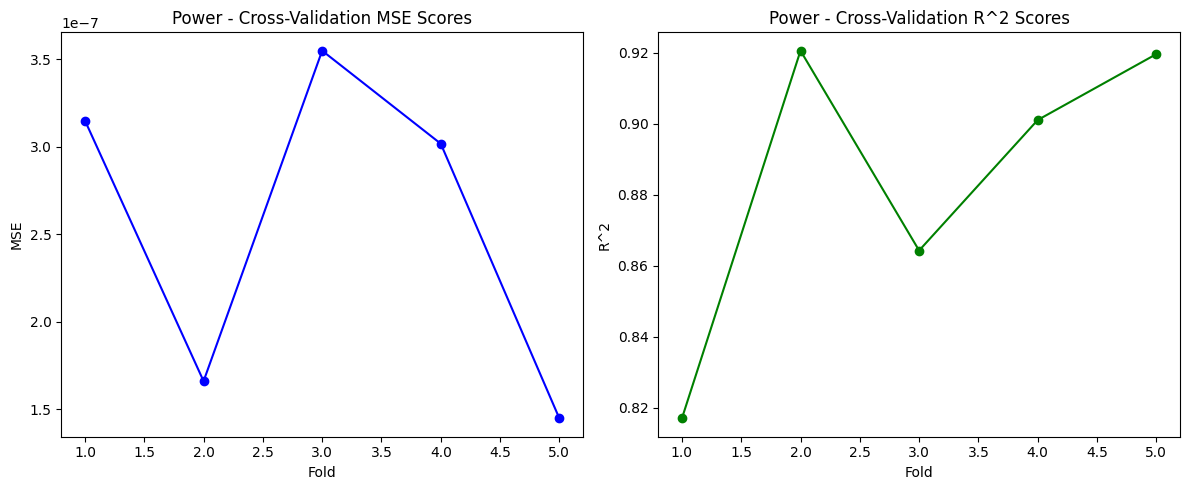

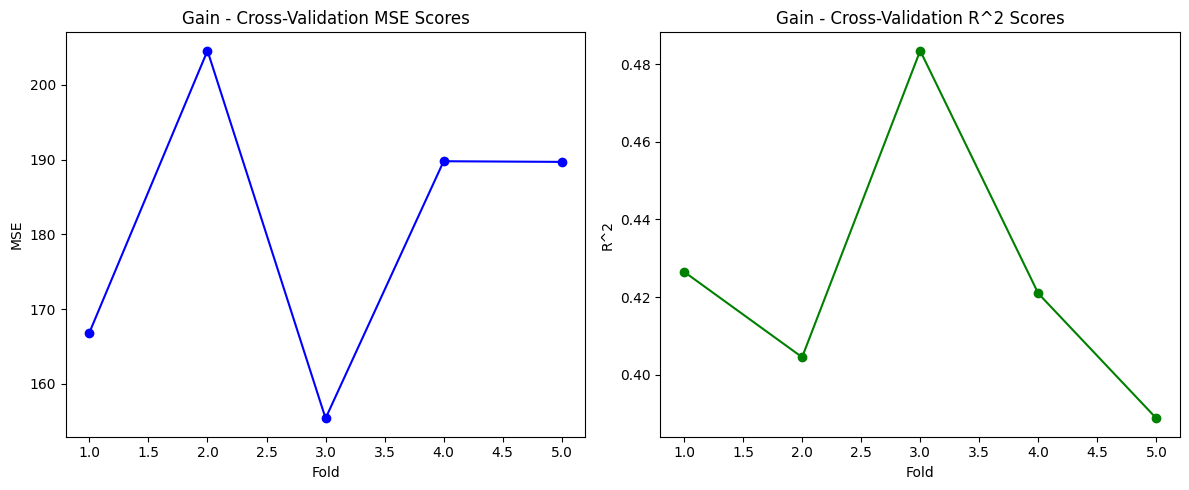

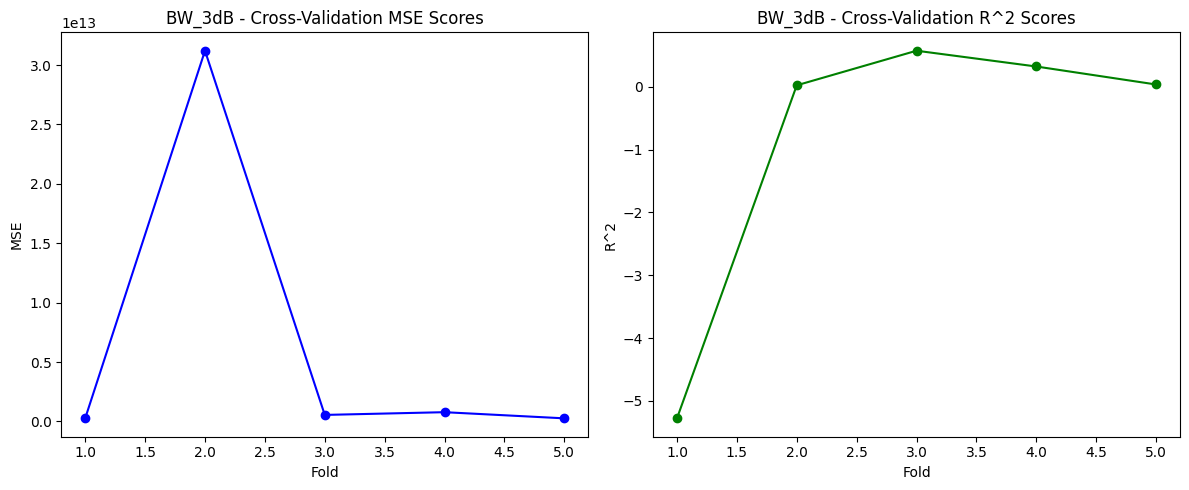

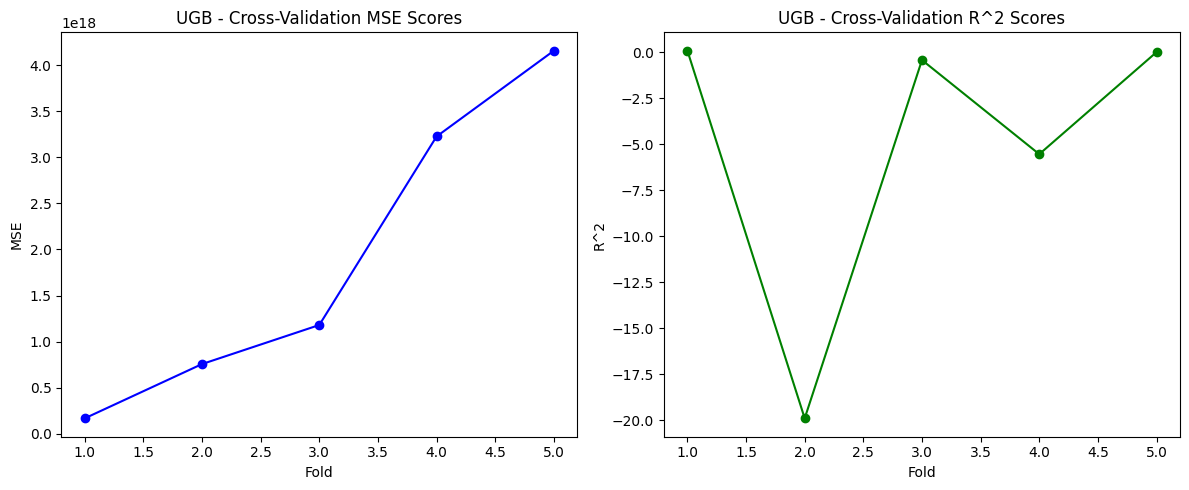

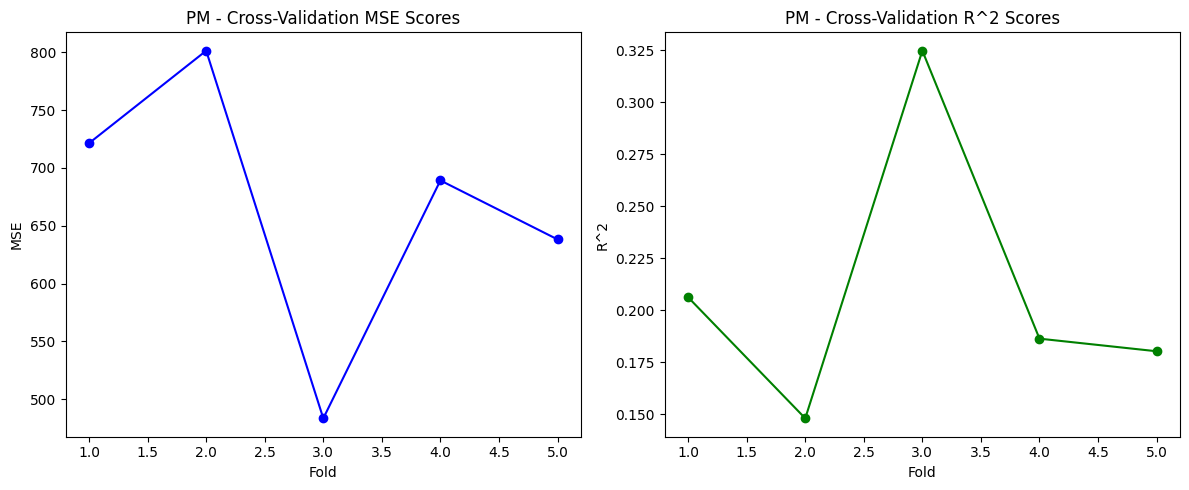

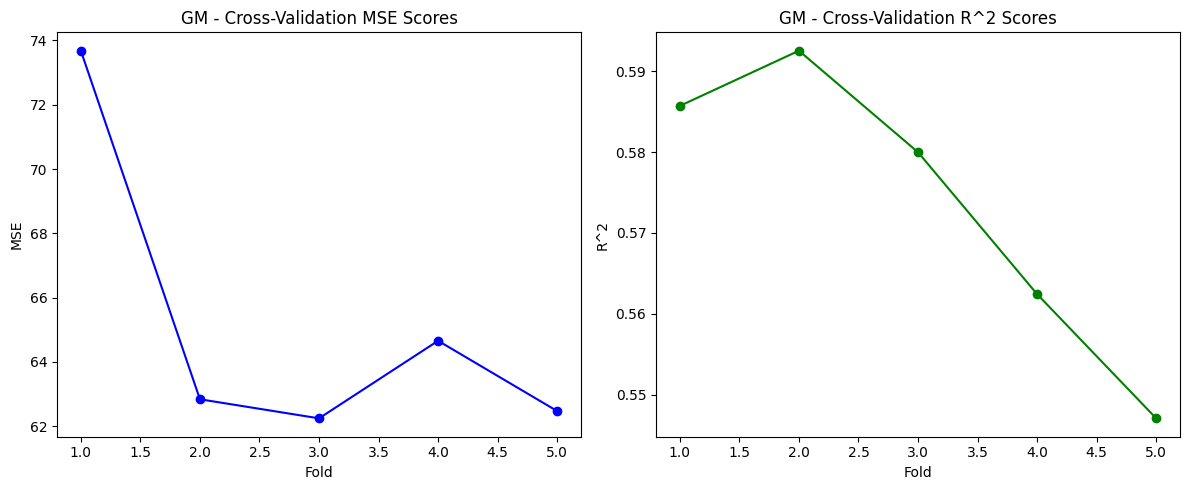

In [ ]:
# evaluate XGBoost model
sky_model = xgb_model.fit(X, y)
sky_results, sky_test_mse_list, sky_test_r2_list = evaluate_model(sky_model, Xsky, ysky)

In [ ]:
print("SKY130 XGboost Evaluate results")
print(sky_results)

SKY130 XGboost Evaluate results
            Cross-Validation MSE (± Standard deviation) Cross-Validation R2
Power                                       0.00 ± 0.00            0.884514
Gain                                     181.25 ± 17.69            0.424867
BW_3dB             6611408148876.13 ± 12301332839092.36           -0.865177
UGB     1897381238687501568.00 ± 1529165783698839552.00           -5.149416
PM                                      666.70 ± 105.86            0.209153
GM                                         65.18 ± 4.33            0.573545


**Observations from results table:**
* "Power" is predicted accurately, with high R² values indicating excellent model performance. However, its MSE is has 0.00 ± 0.00, maybe due to overfitting

* Gain and GM showed moderate performance, indicating some level of accuracy but still with significant room for improvement.
The model struggled significantly with BW_3dB and UGB, as indicated by high MSE values and negative R² scores, meaning the model was unable to capture the relationships for these metrics.

* The PM prediction also showed limitations, with a relatively low R² score and high variability in performance across folds.

**Potential improvement methods:**

* Feature Engineering: Adding or transforming features to better capture non-linear relationships might improve the model's performance, especially for BW_3dB and UGB.
* Model Tuning: Further hyperparameter tuning, or switching to more complex models, such as ensemble methods, might help capture relationships for metrics where the model underperformed.
* Ensemble Learning: Combining multiple models, such as Random Forests or Gradient Boosting Machines, may improve overall stability and reduce errors for challenging metrics.

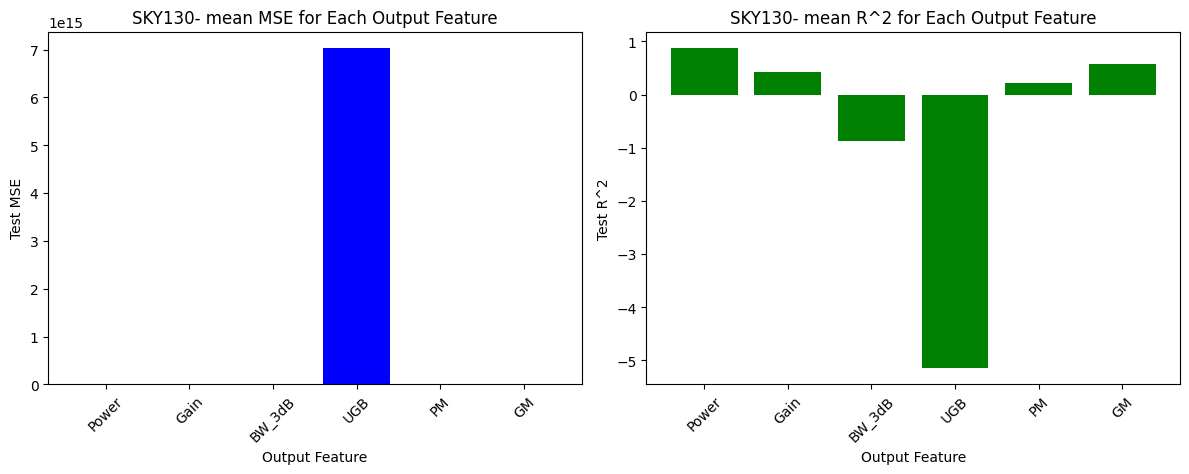

In [ ]:
#plot Sky130 XGBoost mean MSE and R^2 Graph
plot_mean_results(sky_results, sky_test_mse_list, sky_test_r2_list, "SKY130")

**Obervations from "mean" plots:**
* "Power" is predicted well, with a high R² score indicating the model's ability to explain most of its variance.

* UGB shows the largest challenge, with both extremely high MSE and highly negative R² scores, indicating that the model fails to make accurate predictions for this metric.

* BW_3dB also shows poor performance with a negative R² score, suggesting difficulty in accurately predicting this metric.

* The model performs moderately for Gain, PM, and GM, with R² scores indicating some level of explanatory power, but with significant room for further improvement.

##5.2. SHAP Explanations for SKY130

**Note**: Sometimes the SHAP values might be very small in magnitude (e.g., 10^-5 or 10^-6). Depending on the precision used in the graphical representation, such small values could be represented as zero

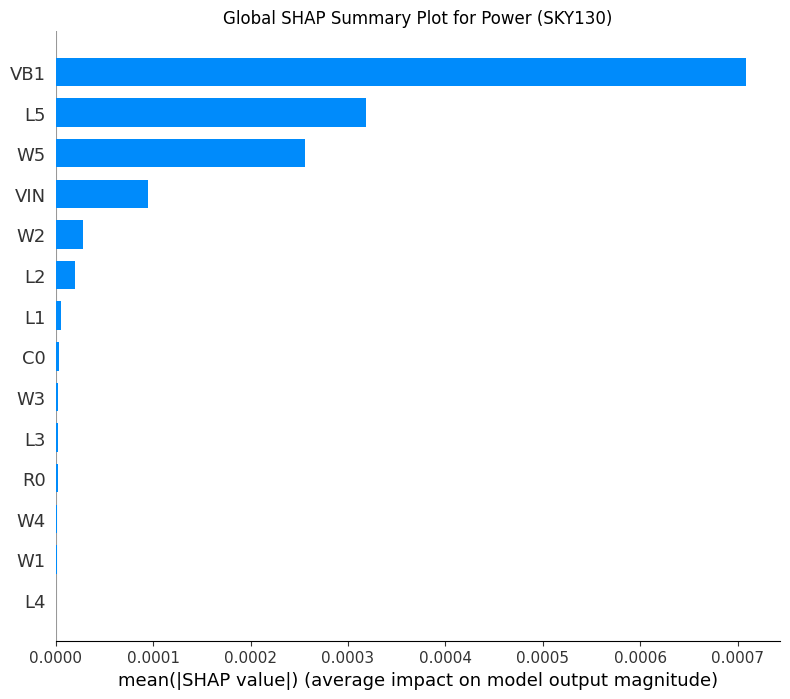

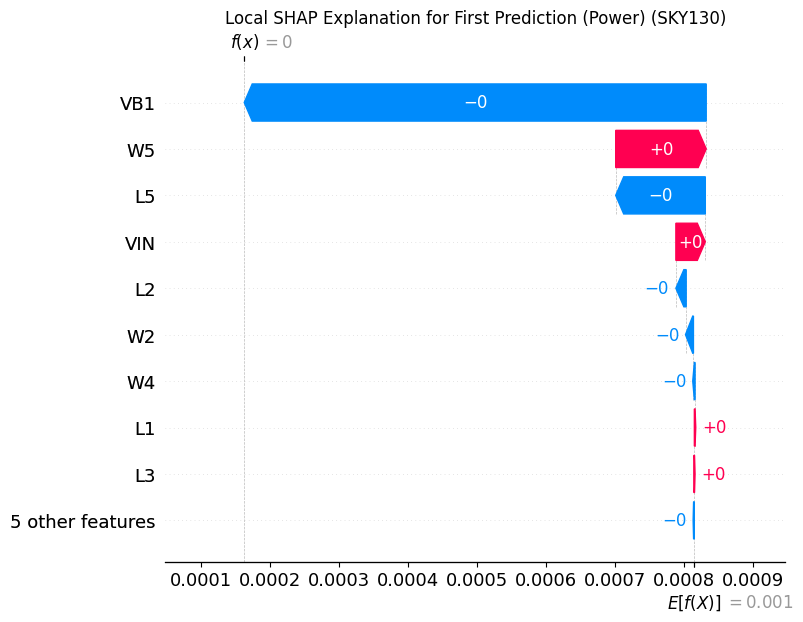

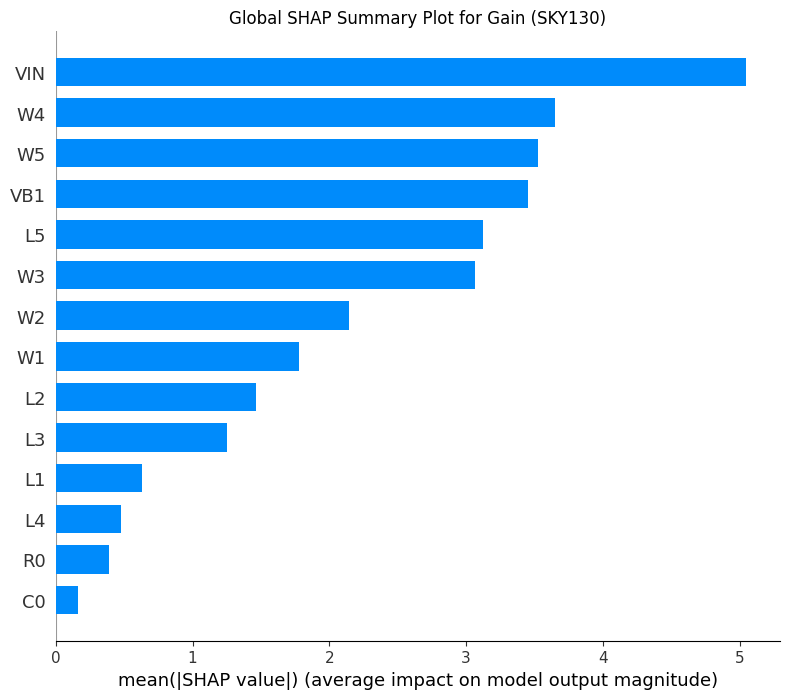

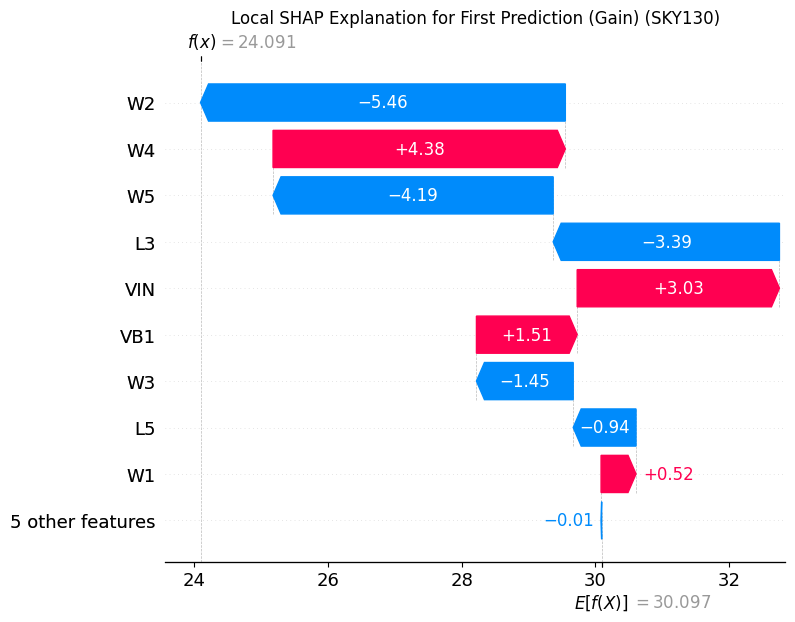

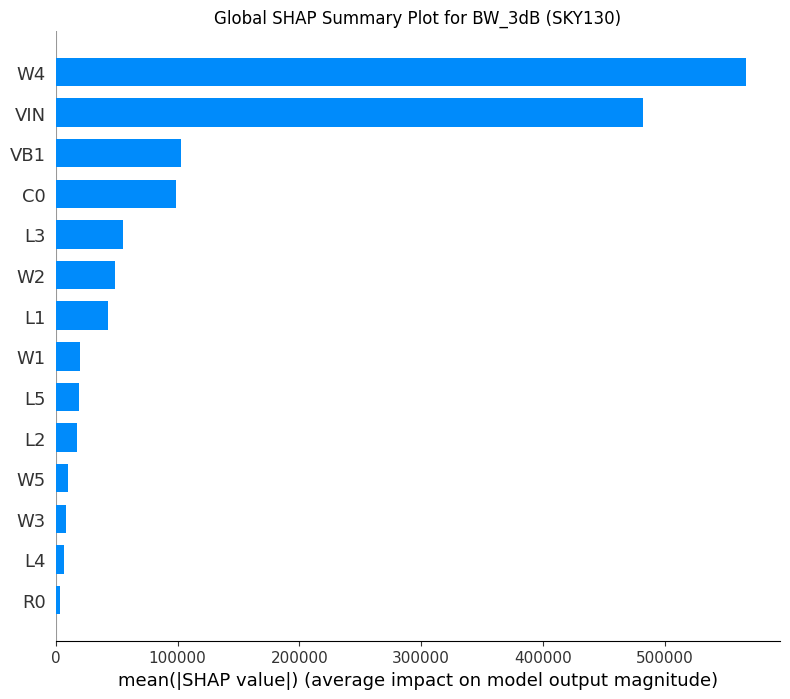

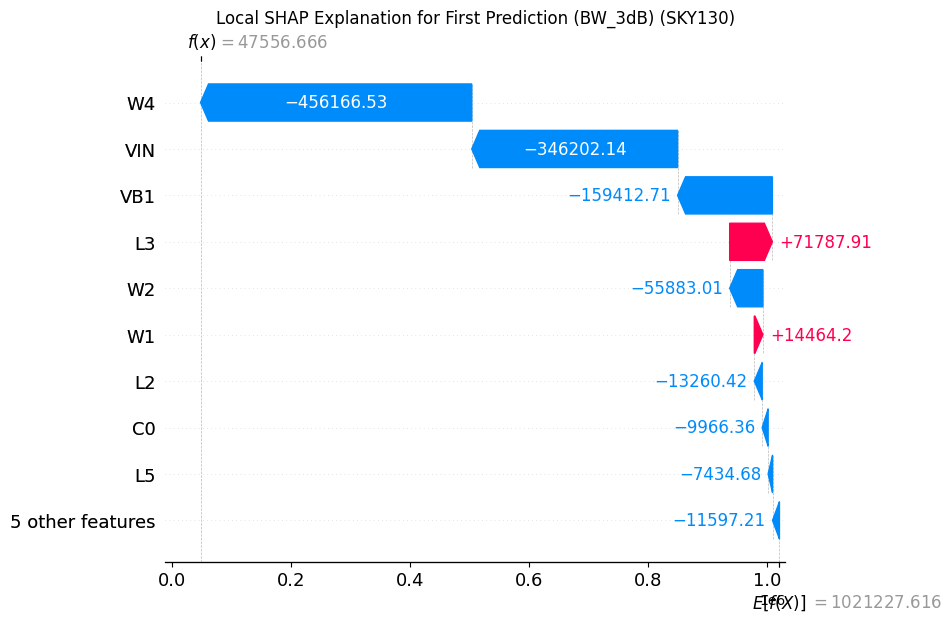

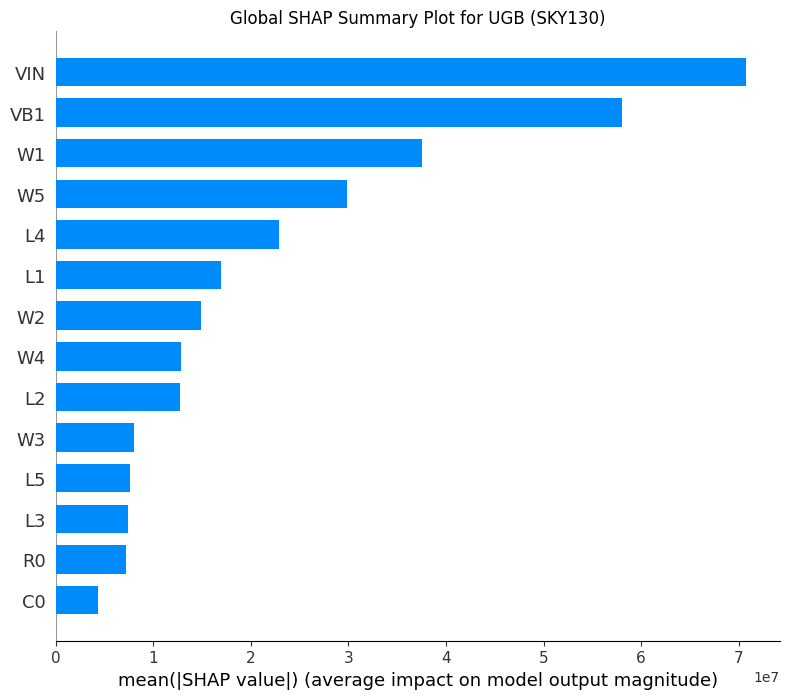

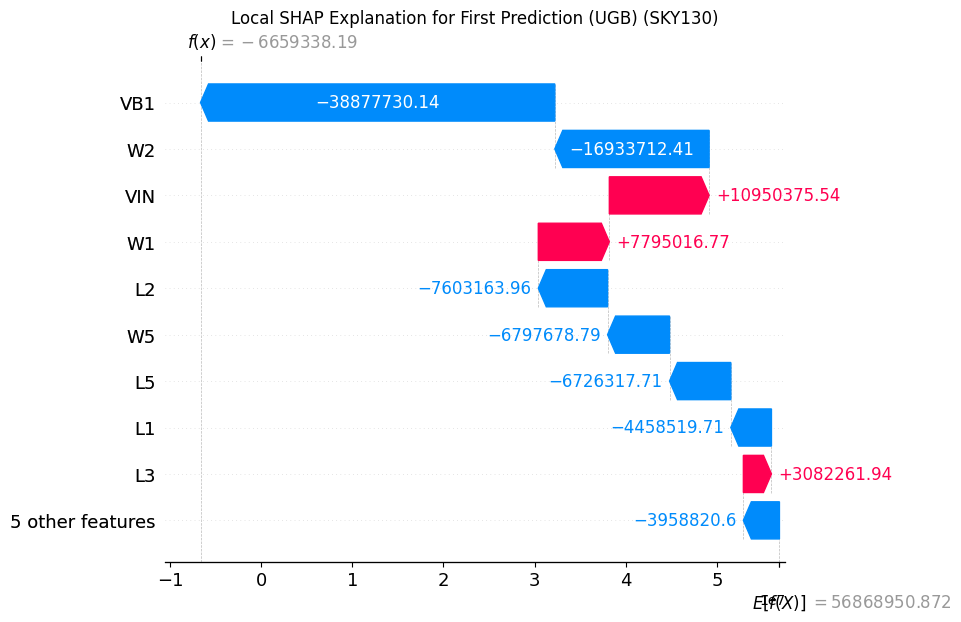

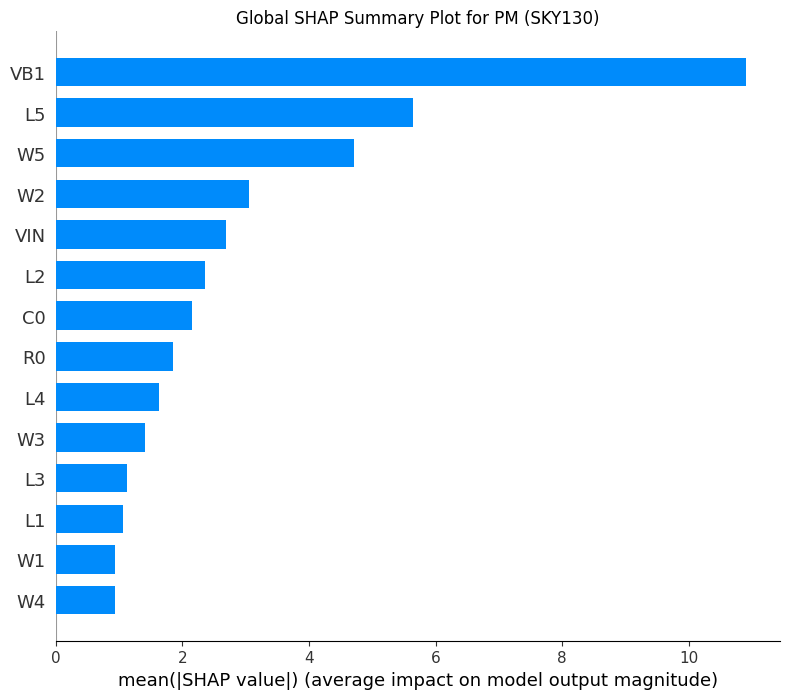

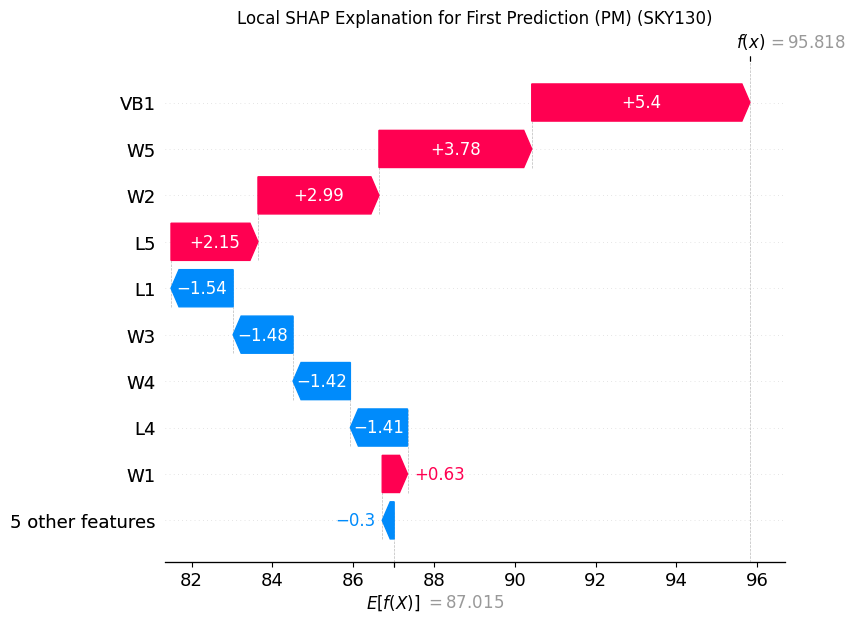

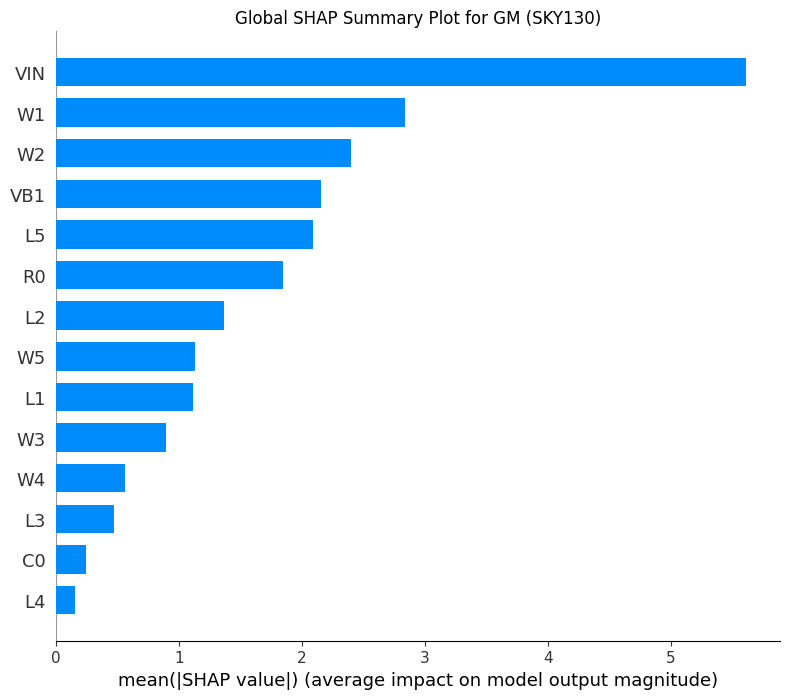

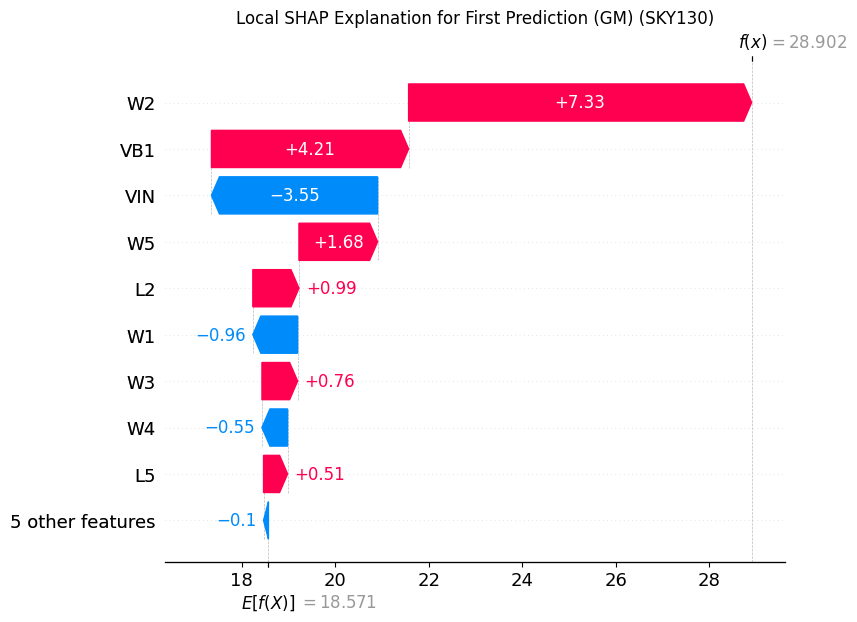

In [ ]:
# Global and Local SHAP Explanations for SKY130 fine-tuned models
for output in output_columns:
    sky_model.fit(Xsky, ysky[output])
    explainer = shap.Explainer(sky_model, Xsky)
    shap_values = explainer(Xsky)

    # Global SHAP summary plot
    plt.title(f"Global SHAP Summary Plot for {output} (SKY130)")
    shap.summary_plot(shap_values, Xsky, feature_names=input_columns, show=False, plot_type= "bar")
    plt.show()

    # Local SHAP explanation for the first instance
    plt.title(f"Local SHAP Explanation for First Prediction ({output}) (SKY130)")
    shap.waterfall_plot(
        shap.Explanation(values=shap_values[0].values,
                         base_values=shap_values[0].base_values,
                         feature_names=input_columns)
    )

    plt.show()

###5.2.1. "Power" explanation result
* Global analysis: VB1, L5, and W5 as the top three most influential features for Power prediction, with VB1 having the largest impact.

* Local analysis: VB1 was the strongest factor influencing the prediction, followed by W5 and L5. VB1 had a negative effect on the Power prediction, while other parameters played a moderate or negligible role.

* Recommendation: designer should focus on tuning **VB1, L5, and W5** to effectively manage the power consumption. Other features such as C0, R0, W3 could be neglected.


###5.2.2. "Gain" explanation result
* Global Analysis: VIN was identified as the most influential feature in determining the gain. W4, W5, VB1, and L5 also had significant impact on Gain predictions, indicating that transistor dimensions play a crucial role in controlling the Gain.

* Local Analysis: W2 had the strongest negative impact on the Gain prediction for the given instance, while W4 had the highest positive contribution. Other features such as W5, L3, and VIN played more moderate roles, with a mix of positive and negative effects.

* Recommendation: deisgners should focus on **W4** if they want to increase the gain. **W5, L5, VB1** and input voltage **VIN** are also crutial. C0, R0 could be neglected when optimizing the gain.


###5.2.3. "BW_3dB" explanation result
* Global Analysis: W4 was found to be the most critical feature affecting the BW_3dB prediction. VIN also had a high influence on the output. Features such as R0, W5, and L5 showed minimal impact, suggesting that they may not play significant roles in determining the BW_3dB value.

* Local Analysis: W4, VIN, and VB1 had the highest negative impacts on the prediction, contributing to a reduction in the BW_3dB value for this instance.
L3 and W1 had a positive influence on the predicted BW_3dB, suggesting their potential for enhancing bandwidth under specific conditions.

* Recommendation: In order to improve the 3-dB-attenuation bandwidth, **W4, VIN, and VB1** should be noticed.


##5.2.4. "UGB" explanation result
* Global Analysis: VIN has the highest average impact on the model output, indicating that it is the most influential feature in determining the UGB in the SKY130 technology. VB1 is the second most important parameter, followed by W1 and W5, suggests that these bias voltages and widths are critical to achieving the desired performance. W1, W5, L4, L1, W2 also have significant contributions to the model output, impacting UGB values, albeit to a lesser extent compared to VIN and VB1.

* Local Analysis: VB1 and W2 have the most significant negative impact on the UGB for this specific prediction. VIN and W1 have strong positive contributions, indicating their values help in increasing UGB for this specific configuration.

* Recommendation: In order to manage the unity gain bandwidth effectively, designers should focus on tuning **VIN, VB1, W1** and **W2**.

##5.2.5. "PM" explanation result
* Global Analysis: VB1 has the highest average impact on the model output, indicating that it is the most influential feature in determining the PM in the SKY130 technology. L5 is the second most important parameter, W5, W2, VIN, L2 also have significant contributions to PM values, although to a lesser extent compared to VB1 and L5.

* Local Analysis: VB1 has a strong positive contribution to PM, indicating that the value of VB1 is effective in enhancing PM. W5, W2, and L5 also contribute positively, suggesting that these features are beneficial for improving PM in the given prediction. L1, W3, W4, and L4 have the most significant negative impacts on the Phase Margin for this specific prediction. They decrease the PM value, implying that their specific values may not be optimal for achieving higher PM.

* Recommendation: In order to increase phase margin of the op-amp, designers should foucs on tuning **VB1, W5, W2, and L5**.


##5.2.6. "GM" explanation result
* Global Analysis: VIN has the highest average impact on determining the gain margin (GM) in the op-amp, indicating its critical role in achieving optimal circuit stability. W1, W2, VB1 and L5 are also influential in determining GM.

* Local Analysis: W2 has the largest positive impact, suggesting it plays a crucial role in predicting the GM. VB1 also contributes positively, implying that its value is beneficial in enhancing the prediction of the GM. W5 and L2 have smaller positive contributions. VIN has a significant negative impact on GM. W1 and W4 also contribute negatively, albeit to a lesser degree than VIN.

* Recommendation: If designers want ro increase the value of gain margin, they should focus on tuning **W2, VB1**, and also take **W5 and L2** into account if neccessary.

#5. Conclusions and Future Works
This study presented a comprehensive approach to modeling and evaluating the performance of operational amplifiers (op-amps) using data-driven techniques. By implementing and comparing XGBoost and Random Forest models, it was found that XGBoost generally outperformed Random Forest. Additionally, the use of SHAP (SHapley Additive exPlanations) provided significant insights into the contributions of individual features to model predictions, enabling circuit designers to focus on optimizing parameters like VB1 and W5 for enhanced performance. Extending the analysis to the SKY130 technology node through transfer learning demonstrated the adaptability of the proposed methodology, further solidifying its utility in various design contexts.

Despite these achievements, the study faced limitations including model instability, poor performance on "UGB" and "BW_3dB," and data leakage during preprocessing, where normalization across the entire dataset influenced cross-validation results. Overfitting and limited feature engineering also hindered performance, especially for complex relationships.

Future work should address these issues by adopting fold-specific preprocessing to prevent data leakage, enhancing feature engineering to capture nonlinearities, and applying advanced tuning and ensemble methods to improve stability. Expanding the approach to other technologies and validating predictions with real-world hardware will further enhance practical relevance. These improvements aim to refine data-driven analog circuit design, optimizing performance for real-world applications.